In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
import os
pd.set_option('display.max_columns', 30)

# load data

In [2]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [3]:
# Import samplesheets
cols = ["model_id", "BROAD_ID", "tissue", "cancer_type"]
col_rename = dict(
    ModelID="BROAD_ID",
    SangerModelID="model_id",
    SampleCollectionSite="tissue",
    OncotreeLineage="cancer_type",
)
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv")

ss_depmap = pd.read_csv(f"{data_folder}/depmap24Q4/Model.csv")
ss_depmap.rename(columns=col_rename, inplace=True)

# Map sample IDs to Sanger IDs
samplesheet = pd.concat(
    [
        ss_cmp[cols].dropna().assign(source="sanger"),
        ss_depmap[cols].dropna().assign(source="broad"),
    ]
)
samplesheet = samplesheet.groupby("model_id").first().reset_index()
samplesheet.replace(
    {
        "tissue": dict(
            large_intestine="Large Intestine",
            lung="Lung",
            ovary="Ovary",
            haematopoietic_and_lymphoid_tissue="Haematopoietic and Lymphoid",
            bone_marrow="Other tissue",
            upper_aerodigestive_tract="Other tissue",
            ascites="Other tissue",
            pleural_effusion="Other tissue",
        )
    },
    inplace=True,
)
tissue_map = samplesheet.set_index("model_id").to_dict()["tissue"]

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
# growth = growth.dropna(subset=["day4_day1_ratio"])

In [4]:
growth.shape

(964, 6)

In [5]:
samplesheet["model_name"] = samplesheet["model_id"].map(
    ss_cmp.set_index("model_id")["model_name"]
)
samplesheet["gender"] = samplesheet["model_id"].map(
    ss_cmp.set_index("model_id")["gender"]
)

In [6]:
samplesheet.head()

model_id    BROAD_ID                       tissue          cancer_type  \
0  SIDM00001  ACH-000405  Haematopoietic and Lymphoid  Other Blood Cancers   
1  SIDM00002  ACH-002340    Peripheral Nervous System        Neuroblastoma   
2  SIDM00003  ACH-002159                         Skin             Melanoma   
3  SIDM00005  ACH-000044                       Breast     Breast Carcinoma   
4  SIDM00006  ACH-001552                         Skin  Other Solid Cancers   

   source     model_name   gender  
0  sanger          MEC-1     Male  
1  sanger        NBsusSR     Male  
2  sanger            M14     Male  
3  sanger  MDA-MB-134-VI   Female  
4  sanger          MCC26  Unknown

In [7]:
samplesheet['tissue'].unique()

array(['Haematopoietic and Lymphoid', 'Peripheral Nervous System', 'Skin',
       'Breast', 'Ovary', 'Large Intestine', 'Esophagus', 'Lung',
       'Head and Neck', 'Central Nervous System', 'Kidney', 'Soft Tissue',
       'Bladder', 'Bone', 'Thyroid', 'Endometrium', 'Stomach', 'Pancreas',
       'Liver', 'Cervix', 'Eye', 'Prostate', 'Biliary Tract', 'Uterus',
       'Testis', 'Other tissue', 'Placenta', 'Small Intestine',
       'Adrenal Gland', 'Vulva', 'Unknown'], dtype=object)

In [8]:
tissue_type_filtered_cell_lines = samplesheet[
    samplesheet["tissue"] != "Haematopoietic and Lymphoid"
]["model_id"].values

In [9]:
PALETTE_TTYPE = {
    "Lung": "#007fff",
    "Prostate": "#665d1e",
    "Stomach": "#ffbf00",
    "Central Nervous System": "#fbceb1",
    "Skin": "#ff033e",
    "Bladder": "#ab274f",
    "Haematopoietic and Lymphoid": "#d5e6f7",
    "Kidney": "#7cb9e8",
    "Thyroid": "#efdecd",
    "Soft Tissue": "#8db600",
    "Head and Neck": "#e9d66b",
    "Ovary": "#b284be",
    "Bone": "#b2beb5",
    "Endometrium": "#10b36f",
    "Breast": "#6e7f80",
    "Pancreas": "#ff7e00",
    "Peripheral Nervous System": "#87a96b",
    "Cervix": "#c9ffe5",
    "Large Intestine": "#9f2b68",
    "Liver": "#00ffff",
    "Vulva": "#008000",
    "Esophagus": "#cd9575",
    "Biliary Tract": "#72a0c1",
    "Other tissue": "#a32638",
    "Small Intestine": "#9966cc",
    "Placenta": "#f19cbb",
    "Testis": "#e32636",
    "Adrenal Gland": "#3b7a57",
    "Uterus": "#7a3b5e",
    "Unknown": "#a32638",
    "Eye": "#ff1493",
}

In [10]:
# timestamp = "20250225_145621"
timestamp = "20250508_160635"
# Datasets - synthetic
## Transcriptomics
gexp_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_transcriptomics.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [11]:
gexp_df.head()

A1BG     A1CF      A2M    A2ML1   A4GALT     AAAS     AACS  \
SIDM00001  2.82538 -5.70426 -2.36943 -5.65178 -0.10823  6.22312  5.83138   
SIDM00003  2.91686 -4.58956  4.95305 -3.92630 -0.39806  5.92625  5.32032   
SIDM00005  4.40266 -2.85698  0.48718 -2.99845 -0.21806  5.78682  5.83291   
SIDM00006  1.74757 -4.83128  3.94680 -5.22547  1.99907  5.20366  4.98912   
SIDM00007  2.02377 -5.63217  1.52301 -5.57509  2.48695  5.36237  5.01744   

             AADAC    AADAT    AAGAB     AAK1    AAMDC     AAMP     AAR2  \
SIDM00001 -6.90987 -4.67730  6.34538  5.14489  1.66870  6.97447  5.62169   
SIDM00003 -5.05715  3.02310  6.07567  6.00542  2.90936  7.07377  5.72689   
SIDM00005 -5.39140  1.52344  6.25988  4.83239  3.95465  6.83037  5.54105   
SIDM00006 -2.64693  3.87574  6.76275  5.94486  3.55864  6.61901  5.92075   
SIDM00007 -2.88926  3.48025  6.80446  6.04640  3.72342  6.80418  5.54422   

              AARD  ...   ZSWIM7   ZSWIM8   ZSWIM9     ZUP1     ZW10   ZWILCH  \
SIDM00001 -1.94047  ...  2.44649  5.94140  3.85223  4.02301  4.97979  5.77335   
SIDM00003 -0.57865  ...  3.60362  6.50600  3.32266  3.63668  4.82583  5.97028   
SIDM00005  0.16623  ...  4.28455  7.31978  3.01796  3.71317  3.87411  5.47598   
SIDM00006 -0.34966  ...  3.27127  4.91918  3.24888  4.19828  5.76696  6.74672   
SIDM00007 -1.59533  ...  3.26508  5.31243  3.84018  4.08543  5.47159  6.31749   

             ZWINT     ZXDA     ZXDB     ZXDC   ZYG11A   ZYG11B      ZYX  \
SIDM00001  7.34118  1.53654  3.88676  4.74087  0.73578  4.17088  5.87244   
SIDM00003  6.72503  1.39277  3.45342  5.18576 -1.36144  5.40842  7.15333   
SIDM00005  7.33651  2.91215  4.26529  5.49773  2.71013  5.08088  5.11085   
SIDM00006  6.54314  2.71483  4.25830  3.83213  1.47279  5.92293  7.55891   
SIDM00007  6.21000  2.95330  4.40004  3.65591  1.68448  6.02536  7.39677   

             ZZEF1     ZZZ3  
SIDM00001  6.69263  5.17185  
SIDM00003  6.20057  6.02651  
SIDM00005  5.94125  5.44129  
SIDM00006  5.36463  6.72187  
SIDM00007  5.65283  6.60225  

[5 rows x 15278 columns]

In [24]:
growth["doubling_time_hours"].describe()

count      949.000000
mean       110.100780
std        412.721409
min         19.230000
25%         43.850000
50%         59.910000
75%         89.760000
max      10598.400000
Name: doubling_time_hours, dtype: float64

In [13]:
growth_filtered_cell_lines = growth[growth["doubling_time_hours"] < 70].index.values

In [14]:
len(growth_filtered_cell_lines)

582

In [15]:
gexp_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/OmicsExpressionGenesExpectedCountProfileVoom.csv",
    index_col=0,
).T
gexp_measured = gexp_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
gexp_measured = gexp_measured[gexp_measured.index.isin(gexp_df.index)]

In [16]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
cas9_measured = cas9_measured[cas9_measured.index.isin(cas9_df.index)]

In [17]:
measured_gexp_only = list(set(gexp_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(gexp_measured.index))
measured_both = list(set(gexp_measured.index) & set(cas9_measured.index))
measured_no_cas9 = list(set(cas9_df.index) - set(cas9_measured.index))

In [18]:
measured_groups = {
    "both": measured_both,
    "gexp_only": measured_gexp_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [19]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)
df_res_vae_annot["log10fdr_orig"] = -np.log10(df_res_vae_annot["fdr_orig"])
df_res_vae_annot["log10fdr_vae"] = -np.log10(df_res_vae_annot["fdr_vae"])
df_res_vae_annot["diff_log10fdr"] = (
    df_res_vae_annot["log10fdr_vae"] - df_res_vae_annot["log10fdr_orig"]
)

In [20]:
df_res_vae_annot_filtered = df_res_vae_annot.query("fdr_vae < 0.05 and beta_vae > 0")
df_res_vae_annot_filtered = df_res_vae_annot_filtered[
    df_res_vae_annot_filtered["y_id"].isin(gexp_df.columns)
]
# Cap y_id rows to 3 per group
df_res_vae_annot_filtered_cap = (
    df_res_vae_annot_filtered.groupby("y_id").head(3).reset_index(drop=True)
)
df_res_vae_annot_filtered_cap_top = (
    df_res_vae_annot_filtered_cap.sort_values(by="fdr_vae")
    .reset_index(drop=True)
    .head(6000)
)

In [21]:
cas9_df.shape

(1523, 17931)

In [25]:
def plot_scatter(
    cas9_name, gexp_name, measured_groups=None, tissue=None, model_list_df=None, ax=None
):
    """
    Plot scatter colored by tissue type

    Parameters:
    -----------
    cas9_name: str
        Name of the CRISPR-Cas9 gene
    gexp_name: str
        Name of the gene expression gene
    measured_groups: dict, optional
        Not used (kept for backward compatibility)
    tissue: str, optional
        Not used (kept for backward compatibility)
    model_list_df: pd.DataFrame, optional
        DataFrame containing model metadata with 'tissue' column
    ax: matplotlib.axes.Axes, optional
        Axes object to plot on. If None, creates a new figure.
    """
    cas9 = cas9_df[cas9_name]
    gexp = gexp_df[gexp_name]

    # Merge data and get common samples
    df = pd.DataFrame({"CRISPR": cas9, "Expression": gexp})
    df = df.dropna()

    # Calculate correlation
    corr, pval = stats.pearsonr(df["CRISPR"], df["Expression"])

    # Create plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Color by tissue type if model_list_df is provided
    if model_list_df is not None:
        # Map sample indices to tissue types
        df["tissue"] = df.index.map(
            lambda idx: model_list_df.set_index("model_id").loc[idx, "tissue"]
            if idx in set(model_list_df["model_id"])
            else "Unknown"
        )
        
        # Get unique tissues for consistent color mapping
        unique_tissues = sorted(df["tissue"].unique())
        
        # Plot scatter points colored by tissue
        sns.scatterplot(
            data=df,
            x="Expression",
            y="CRISPR",
            hue="tissue",
            palette=PALETTE_TTYPE,
            ax=ax,
            s=20,
            alpha=0.6,
            legend=False,  # Turn off individual legends
            hue_order=unique_tissues,
        )
    else:
        # Simple case: plot all points in green
        ax.scatter(
            df["Expression"],
            df["CRISPR"],
            c="green",
            alpha=0.6,
            s=20,
        )

    # Add regression line
    sns.regplot(
        data=df,
        y="CRISPR",
        x="Expression",
        scatter=False,
        color="black",
        line_kws={"linestyle": "--"},
        ax=ax,
    )

    # Annotate correlation
    ax.annotate(
        f"r = {corr:.3f}\np = {pval:.2e}\nn = {len(df)}",
        xy=(0.05, 0.85),
        xycoords="axes fraction",
        bbox=dict(facecolor="white", alpha=0.8),
        fontsize=8,
    )

    # Labels and title
    ax.set_ylabel(f"{cas9_name} (Cas9)", fontsize=9)
    ax.set_xlabel(f"{gexp_name} (GEXP)", fontsize=9)
    ax.grid(True, alpha=0.3)

    title = f"{cas9_name} (Cas9) vs {gexp_name} (GEXP)"
    ax.set_title(title, fontsize=10)
    ax.tick_params(labelsize=8)

    return ax

In [26]:
df_res_vae_annot_filtered_cap_top.query("y_id =='CDS2' or x_id =='CDS2'")

y_id     x_id  n_orig  beta_orig   lr_orig  covs_orig     pval_orig  \
62    CDS2     CDS1   923.0    0.42130  80.69081      208.0  2.639467e-19   
590   CDS2  ZDHHC23   923.0    0.14365  18.98449      208.0  1.317855e-05   
1814  CDS2    REPS2   923.0    0.14230  19.33405      208.0  1.097319e-05   

          fdr_orig   n_vae  beta_vae     lr_vae  covs_vae      pval_vae  \
62    4.540411e-15  1523.0   0.36791  105.16634     211.0  1.123012e-24   
590   4.122650e-02  1523.0   0.13369   29.47876     211.0  5.653280e-08   
1814  3.296248e-02  1523.0   0.11030   19.76658     211.0  8.749952e-06   

           fdr_vae  skew_orig  skew_mosa               target_detailed target  \
62    4.085518e-21   -1.00569   -0.35216                             1      1   
590   2.056663e-04   -1.00569   -0.35216  No link; Gene not in network      -   
1814  4.547475e-03   -1.00569   -0.35216                             4      4   

      entropy  log10fdr_orig  log10fdr_vae  diff_log10fdr  
62    0.72541      14.342905     20.388753       6.045848  
590   0.72541       1.384824      3.686837       2.302013  
1814  0.72541       1.481980      2.342230       0.860250

In [79]:
RESULT_DIR = "./validation_growth_tissue"
TIMESTAMP = "20251015"

# analysis

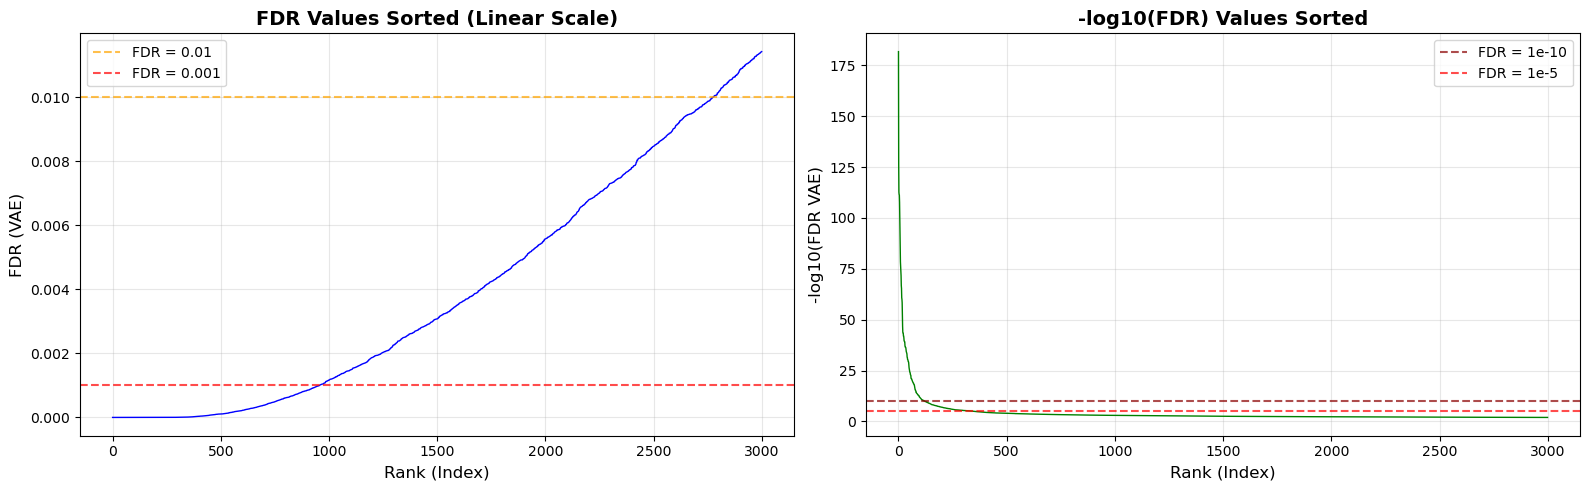

=== FDR VALUE DISTRIBUTION SUMMARY ===
Associations below specific thresholds:
  FDR <= 1e-10: 121 associations (4.0%)
  FDR <= 1e-05: 343 associations (11.4%)
  FDR <= 0.0001: 485 associations (16.2%)
  FDR <= 0.001: 956 associations (31.9%)


In [46]:
# Visualize FDR values to identify potential threshold
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Sort FDR values
fdr_sorted = (
    df_res_vae_annot_filtered_cap_top["fdr_vae"].sort_values().reset_index(drop=True).head(3000)
)

# Plot 1: Regular scale
axes[0].plot(fdr_sorted.index, fdr_sorted.values, linewidth=1, color="blue")
axes[0].set_xlabel("Rank (Index)", fontsize=12)
axes[0].set_ylabel("FDR (VAE)", fontsize=12)
axes[0].set_title("FDR Values Sorted (Linear Scale)", fontsize=14, fontweight="bold")
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.01, color="orange", linestyle="--", label="FDR = 0.01", alpha=0.7)
axes[0].axhline(y=0.001, color="red", linestyle="--", label="FDR = 0.001", alpha=0.7)
axes[0].legend()

# Plot 2: -log10(FDR) scale
log10fdr_sorted = (
    df_res_vae_annot_filtered_cap_top["log10fdr_vae"]
    .sort_values(ascending=False)
    .reset_index(drop=True)
    .head(3000)
)
axes[1].plot(log10fdr_sorted.index, log10fdr_sorted.values, linewidth=1, color="green")
axes[1].set_xlabel("Rank (Index)", fontsize=12)
axes[1].set_ylabel("-log10(FDR VAE)", fontsize=12)
axes[1].set_title("-log10(FDR) Values Sorted", fontsize=14, fontweight="bold")
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=10, color="darkred", linestyle="--", label="FDR = 1e-10", alpha=0.7)
axes[1].axhline(y=5, color="red", linestyle="--", label="FDR = 1e-5", alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics to help identify threshold
print("=== FDR VALUE DISTRIBUTION SUMMARY ===")
print(f"Associations below specific thresholds:")
for threshold in [1e-10, 1e-5, 1e-4, 1e-3]:
    count = (fdr_sorted <= threshold).sum()
    percentage = count / len(fdr_sorted) * 100
    print(f"  FDR <= {threshold}: {count} associations ({percentage:.1f}%)")

In [32]:
df_res_vae_annot_filtered_cap_top.head()

y_id    x_id  n_orig  beta_orig    lr_orig  covs_orig      pval_orig  \
0  FAM50A  FAM50B   923.0    0.75825  775.49438      208.0  1.148490e-170   
1   DDX3X   DDX3Y   923.0    0.70104  628.13085      208.0  1.274517e-138   
2  EIF1AX  EIF1AY   923.0    0.69643  563.47514      208.0  1.474560e-124   
3   DDX3X     UTY   923.0    0.67039  566.34511      208.0  3.502334e-125   
4   DDX3X   USP9Y   923.0    0.66805  569.93911      208.0  5.788442e-126   

        fdr_orig   n_vae  beta_vae     lr_vae  covs_vae       pval_vae  \
0  1.975632e-166  1523.0   0.62305  846.16667     211.0  4.953857e-186   
1  2.192424e-134  1523.0   0.54253  592.67442     211.0  6.564286e-131   
2  2.536539e-120  1523.0   0.54443  528.78237     211.0  5.198192e-117   
3  6.024714e-121  1523.0   0.50949  523.46762     211.0  7.449375e-116   
4  9.957278e-122  1523.0   0.50986  522.08826     211.0  1.486670e-115   

         fdr_vae  skew_orig  skew_mosa                 target_detailed target  \
0  1.802213e-182   -0.62729   -0.38142  No link; CRISPR not in network      -   
1  2.388087e-127    0.54274   -0.18181                               3      3   
2  1.891102e-113    0.61340   -0.24279                               1      1   
3  2.710083e-112    0.54274   -0.18181                               3      3   
4  5.408505e-112    0.54274   -0.18181                               3      3   

   entropy  log10fdr_orig  log10fdr_vae  diff_log10fdr  
0  0.82245     165.704294    181.744194      16.039900  
1  0.83160     133.659076    126.621950      -7.037126  
2  0.83172     119.595758    112.723285      -6.872473  
3  0.83160     120.220064    111.567017      -8.653046  
4  0.83160     121.001859    111.266923      -9.734937

Threshold FDR < 1e-05: 343 total pairs
Threshold FDR < 1e-04: 485 total pairs
Threshold FDR < 1e-03: 956 total pairs

Created figure with 3 rows × 5 columns = 15 total plots

Summary of plotted pairs:
 threshold  pair_rank  y_gene  x_gene  fdr_vae  beta_vae
   0.00001          1    DFFB    GAS2 0.000008   0.18916
   0.00001          2    E2F3     RB1 0.000009   0.14343
   0.00001          3  DDX19A  FAHD2B 0.000009   0.17512
   0.00001          4 TSPAN31  SUCLG2 0.000010   0.17795
   0.00001          5    FLT3    EPN2 0.000010   0.22910
   0.00010          1    CCT2 MARCHF9 0.000096   0.16411
   0.00010          2   DDX55   KCNK6 0.000097   0.17104
   0.00010          3    GAB1    GAB2 0.000097   0.17138
   0.00010          4    OXSM   CPT1A 0.000098   0.12067
   0.00010          5   VPS16    PRPH 0.000099   0.17219
   0.00100          1   TRPS1      CP 0.000984   0.15044
   0.00100          2    MZF1   STAP1 0.000985   0.19157
   0.00100          3  CHCHD3   SARDH 0.000989   0.13834
 

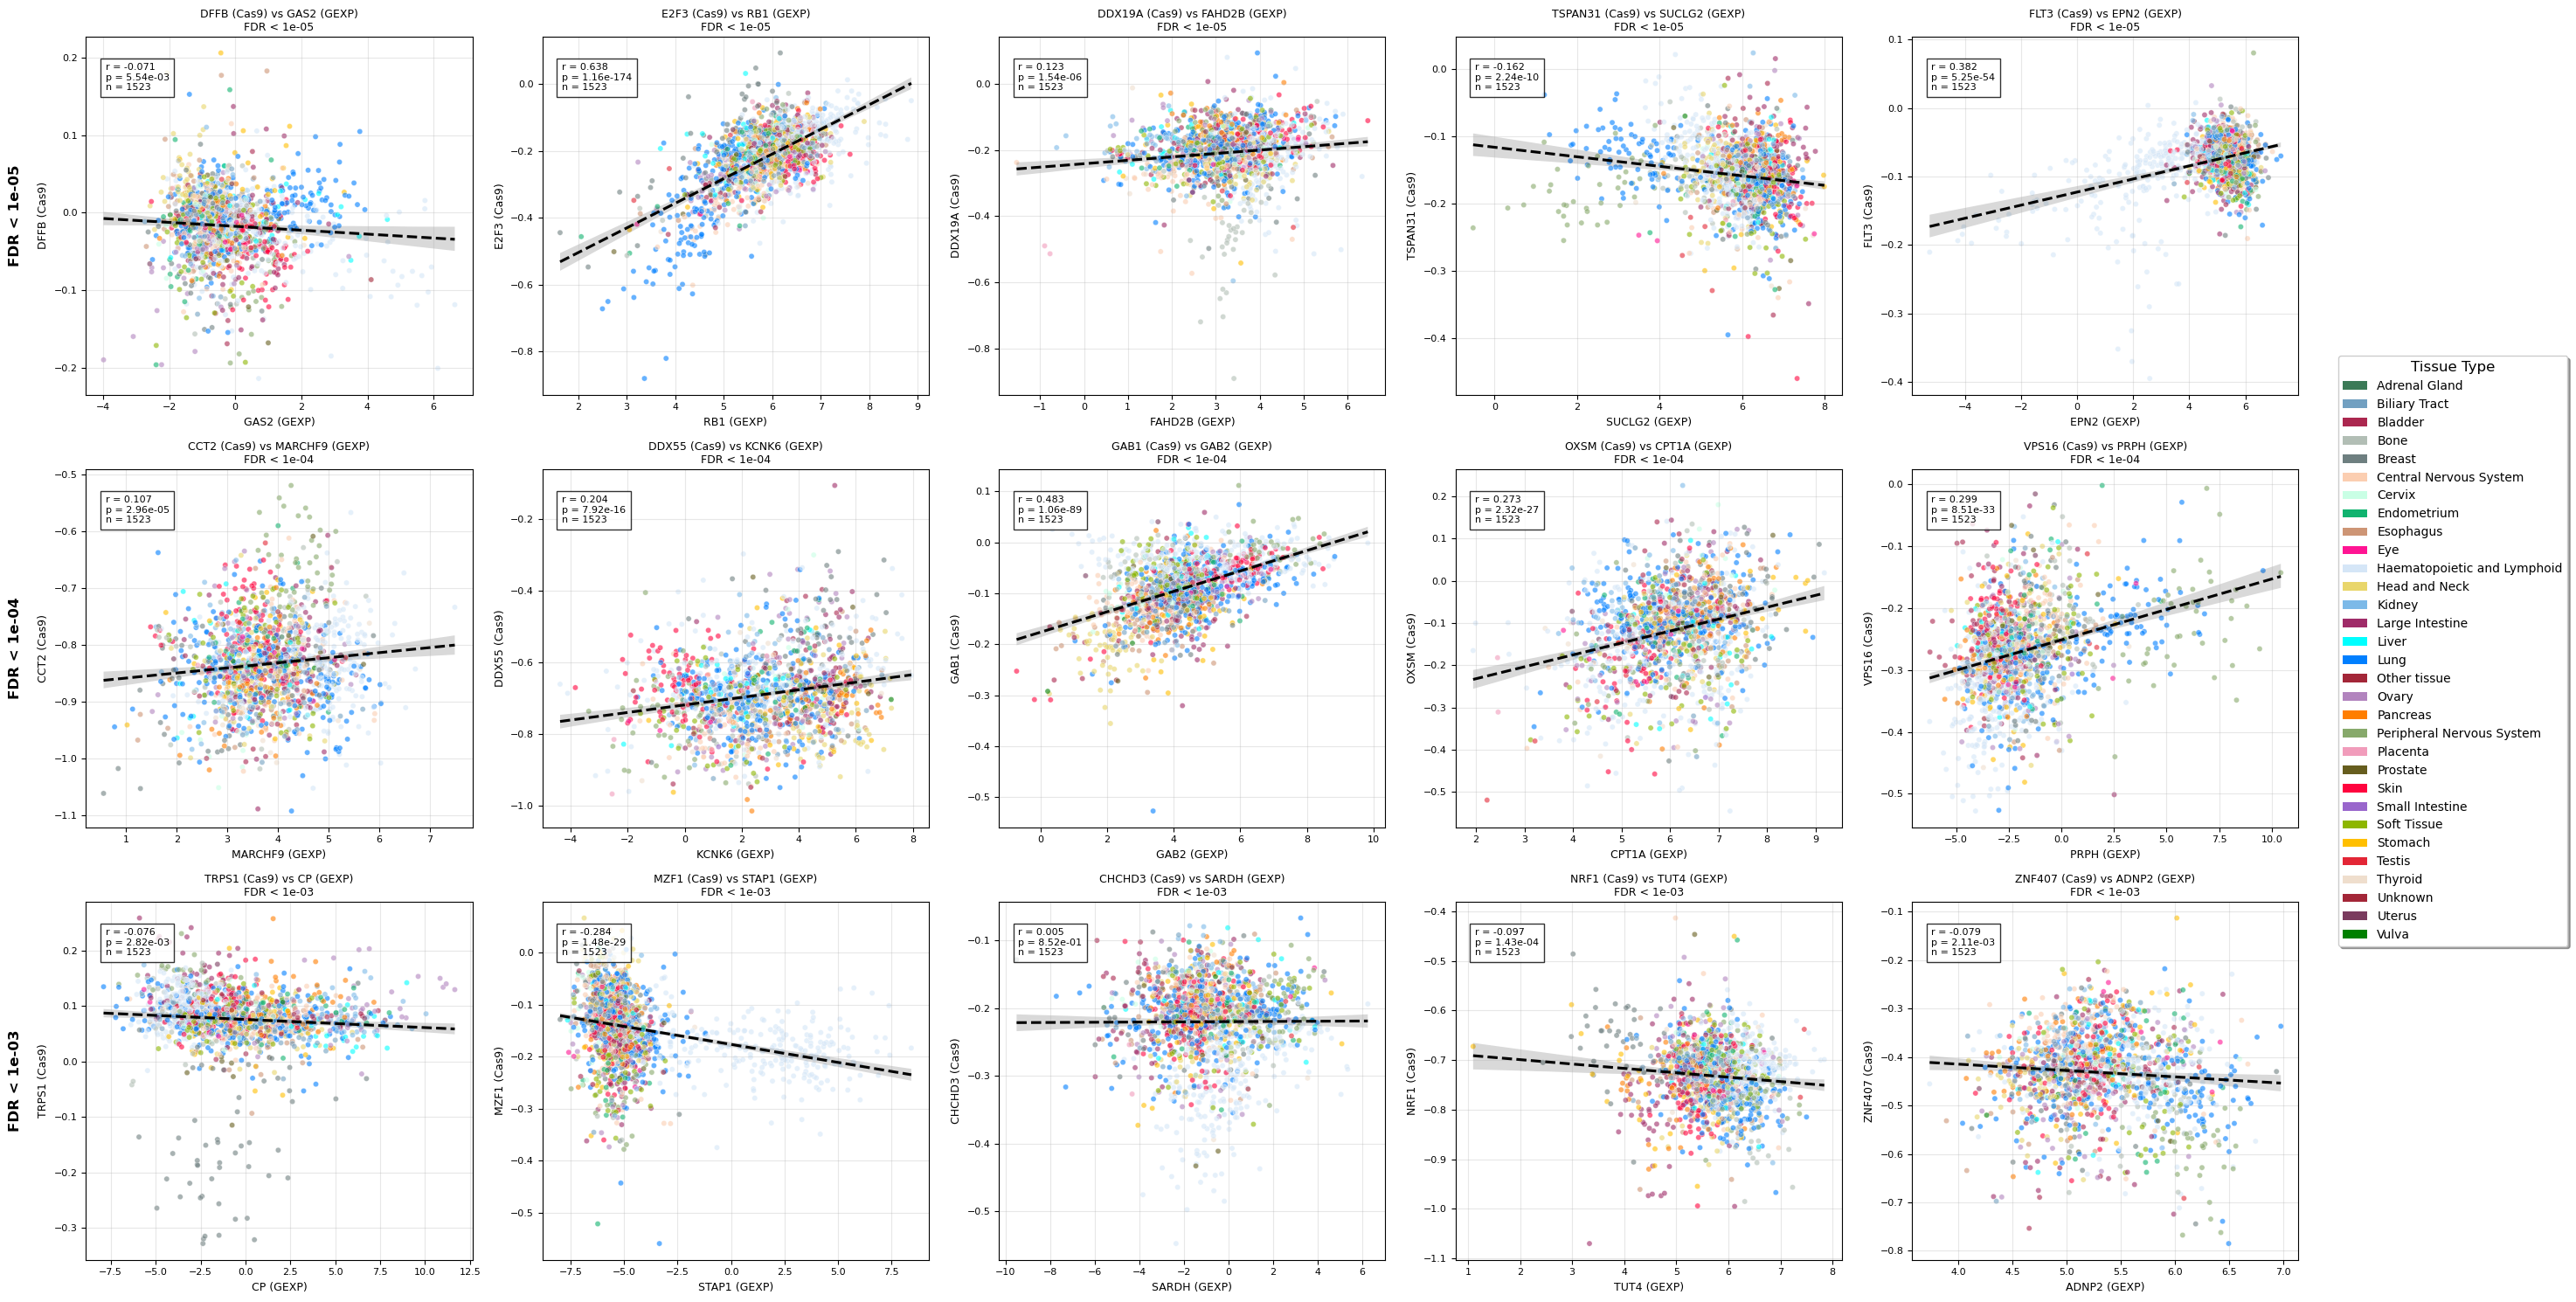

In [30]:
# ============================================================================
# Multi-Threshold FDR Scatter Plot Grid
# Copy this entire cell into your Jupyter notebook after the plot_scatter function
# ============================================================================

# Define thresholds to test
thresholds = [1e-5, 1e-4, 1e-3]
n_pairs_per_threshold = 5

# Calculate grid dimensions
n_rows = len(thresholds)
n_cols = n_pairs_per_threshold

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

# Ensure axes is always 2D array for consistent indexing
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Track statistics for summary
summary_stats = []

# Iterate through thresholds and plot pairs
for row_idx, threshold in enumerate(thresholds):
    # Filter data for current threshold
    filtered_data = df_res_vae_annot_filtered_cap_top[
        df_res_vae_annot_filtered_cap_top["fdr_vae"] < threshold
    ]

    print(f"Threshold FDR < {threshold:.0e}: {len(filtered_data)} total pairs")

    # Get top pairs (using tail to get the last n pairs)
    top_pairs = filtered_data.tail(n_pairs_per_threshold)

    # Check if we have enough pairs
    if len(top_pairs) < n_pairs_per_threshold:
        print(
            f"  Warning: Only {len(top_pairs)} pairs available for threshold {threshold:.0e}"
        )

    # Plot each pair
    for col_idx, row in enumerate(top_pairs.itertuples()):
        ax = axes[row_idx, col_idx]

        # Plot scatter
        plot_scatter(
            row.y_id,
            row.x_id,
            measured_groups=measured_groups,
            model_list_df=samplesheet,
            ax=ax,
        )

        # Modify title to include threshold info
        current_title = ax.get_title()
        ax.set_title(f"{current_title}\nFDR < {threshold:.0e}", fontsize=9, pad=5)

        # Add row label on leftmost plots
        if col_idx == 0:
            # Add a text label outside the plot on the left
            ax.text(
                -0.20,
                0.5,
                f"FDR < {threshold:.0e}",
                transform=ax.transAxes,
                rotation=90,
                verticalalignment="center",
                fontsize=12,
                fontweight="bold",
            )

        # Store stats
        summary_stats.append(
            {
                "threshold": threshold,
                "pair_rank": col_idx + 1,
                "y_gene": row.y_id,
                "x_gene": row.x_id,
                "fdr_vae": row.fdr_vae if hasattr(row, "fdr_vae") else None,
                "beta_vae": row.beta_vae if hasattr(row, "beta_vae") else None,
            }
        )

# Create legend for tissue types on the right side of the figure
from matplotlib.patches import Patch

# Get unique tissues present in the data
unique_tissues = sorted(samplesheet['tissue'].unique())

# Create legend handles for each tissue
legend_handles = [
    Patch(facecolor=PALETTE_TTYPE.get(tissue, '#a32638'), label=tissue)
    for tissue in unique_tissues if tissue in PALETTE_TTYPE
]

# Add figure legend on the right side
fig.legend(
    handles=legend_handles,
    loc='center right',
    bbox_to_anchor=(0.98, 0.5),
    fontsize=10,
    title='Tissue Type',
    title_fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True
)

# Adjust layout to prevent overlap and make room for legend
plt.subplots_adjust(right=0.88)
plt.tight_layout(rect=[0, 0, 0.88, 1])

# Print summary
print(f"\n{'='*80}")
print(
    f"Created figure with {n_rows} rows × {n_cols} columns = {n_rows * n_cols} total plots"
)
print(f"{'='*80}\n")

# Create and display summary DataFrame
summary_df = pd.DataFrame(summary_stats)
print("Summary of plotted pairs:")
print(summary_df.to_string(index=False))

# Optionally save the figure
# fig.savefig('multi_threshold_scatter_plots.png', dpi=300, bbox_inches='tight')

plt.show()

In [60]:
N_TOP_PAIRS = df_res_vae_annot_filtered_cap_top[
    df_res_vae_annot_filtered_cap_top["fdr_vae"] < 1e-4
].shape[0]


Created figure with 10 rows × 5 columns = 50 total plots

Summary of plotted pairs:
 rank  row  col   y_gene   x_gene       fdr_vae  beta_vae
    1    1    1   FAM50A   FAM50B 1.802213e-182   0.62305
    2    1    2    DDX3X    DDX3Y 2.388087e-127   0.54253
    3    1    3   EIF1AX   EIF1AY 1.891102e-113   0.54443
    4    1    4    DDX3X      UTY 2.710083e-112   0.50949
    5    1    5    DDX3X    USP9Y 5.408505e-112   0.50986
    6    2    1   RPP25L    RPP25 1.938438e-108   0.56127
    7    2    2   EIF1AX    KDM5D 1.458479e-100   0.51644
    8    2    3   EIF1AX    DDX3Y  6.953966e-96   0.50970
    9    2    4    INTS6   INTS6L  4.161317e-83   0.53154
   10    2    5  DNAJC19  DNAJC15  3.835960e-79   0.45934
   11    3    1 ATP6V0E1 ATP6V0E2  1.447837e-76   0.58168
   12    3    2    TTC7A    TTC7B  1.609074e-73   0.57301
   13    3    3    NAA10    NAA11  3.025780e-72   0.47415
   14    3    4     SLF1    SIMC1  1.918326e-67   0.45967
   15    3    5    CSTF2   CSTF2T  4.277416e-

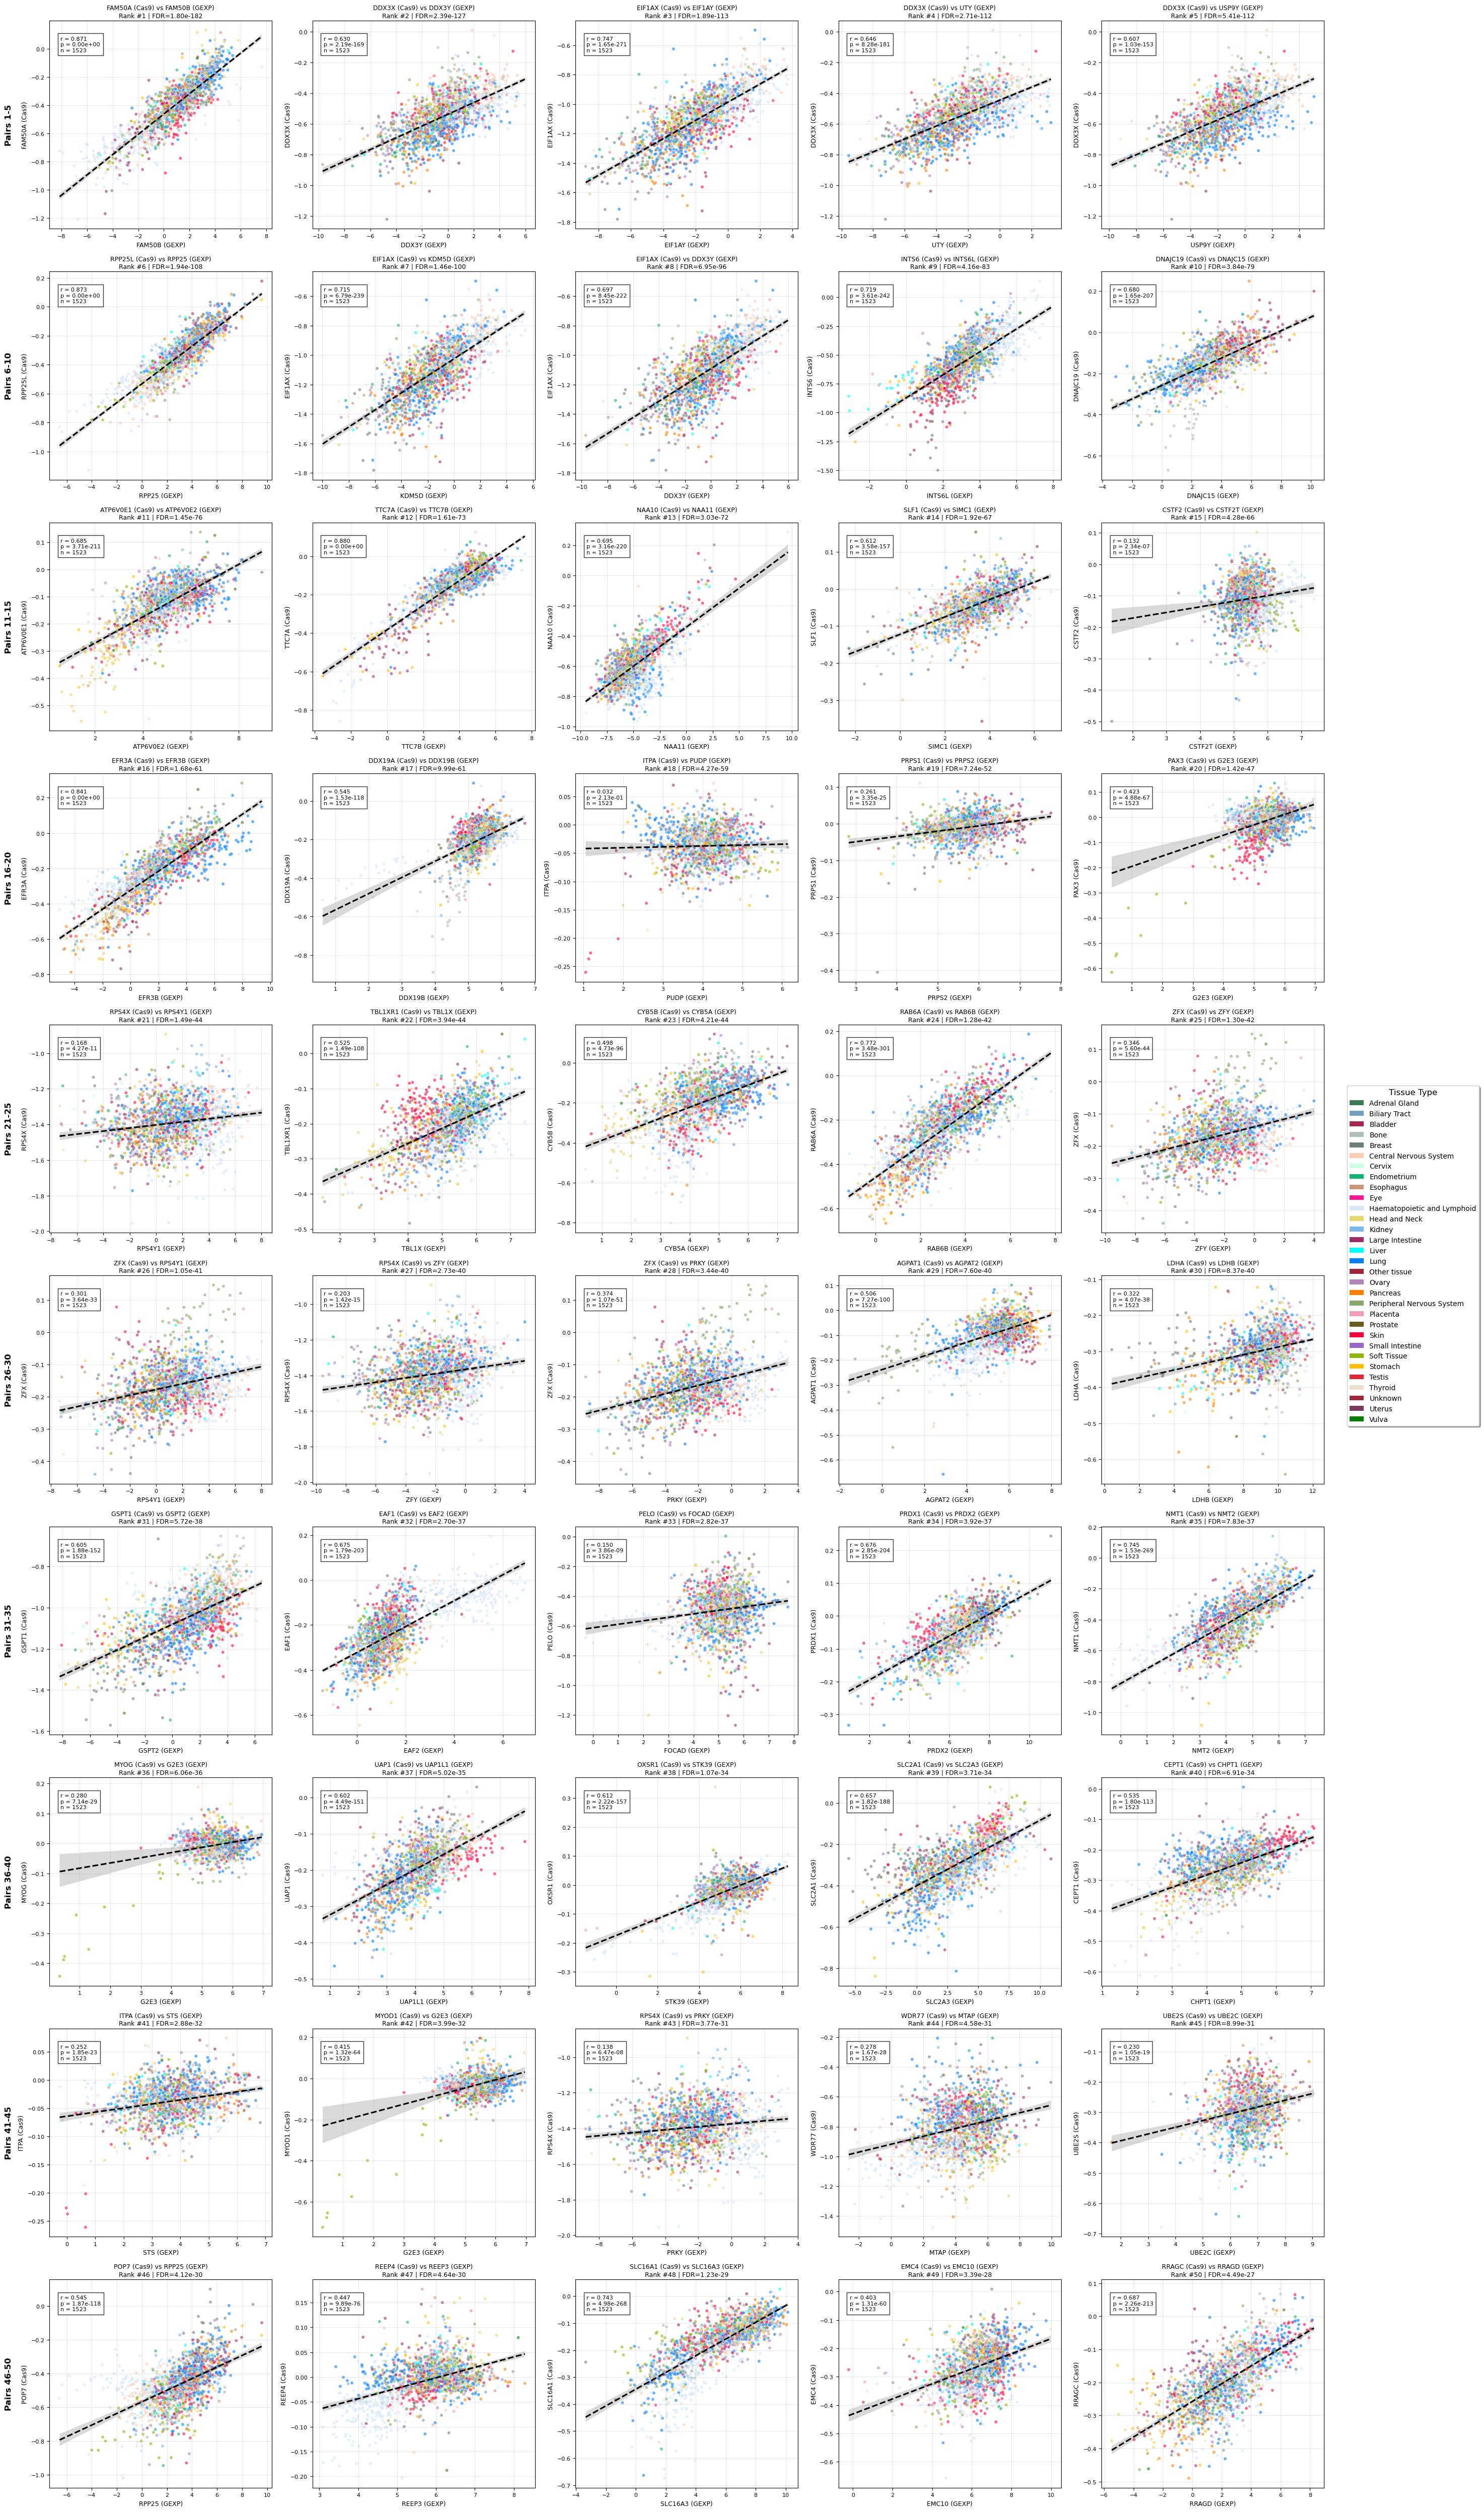

In [86]:
# ============================================================================
# Top-Nx5 FDR Scatter Plot Grid
# Copy this entire cell into your Jupyter notebook after the plot_scatter function
# ============================================================================

n_rows = 10
n_cols = 5

# Get top Nx5 = n_rows * n_cols pairs with the lowest FDR
ordered_pairs = df_res_vae_annot_filtered_cap_top.sort_values("fdr_vae", ascending=True).head(n_rows * n_cols)

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

# Make axes always 2D
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1) 
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

summary_stats = []

# Plot grid: rows and columns
for idx, row in enumerate(ordered_pairs.itertuples()):
    row_idx = idx // n_cols
    col_idx = idx % n_cols
    ax = axes[row_idx, col_idx]

    plot_scatter(
        row.y_id,
        row.x_id,
        measured_groups=measured_groups,
        model_list_df=samplesheet,
        ax=ax,
    )

    # Modify title to include rank and FDR info
    current_title = ax.get_title()
    ax.set_title(
        f"{current_title}\nRank #{idx+1} | FDR={row.fdr_vae:.2e}", fontsize=9, pad=5
    )

    # Add row text
    if col_idx == 0:
        ax.text(
            -0.20,
            0.5,
            f"Pairs {row_idx * n_cols + 1}-{(row_idx + 1) * n_cols}",
            transform=ax.transAxes,
            rotation=90,
            verticalalignment="center",
            fontsize=12,
            fontweight="bold",
        )

    summary_stats.append(
        {
            "rank": idx + 1,
            "row": row_idx + 1,
            "col": col_idx + 1,
            "y_gene": row.y_id,
            "x_gene": row.x_id,
            "fdr_vae": getattr(row, "fdr_vae", None),
            "beta_vae": getattr(row, "beta_vae", None),
        }
    )

# Create legend for tissue types on the right side of the figure
from matplotlib.patches import Patch

unique_tissues = sorted(samplesheet["tissue"].unique())
legend_handles = [
    Patch(facecolor=PALETTE_TTYPE.get(tissue, "#a32638"), label=tissue)
    for tissue in unique_tissues
    if tissue in PALETTE_TTYPE
]

fig.legend(
    handles=legend_handles,
    loc="center right",
    bbox_to_anchor=(0.98, 0.5),
    fontsize=10,
    title="Tissue Type",
    title_fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
)

plt.subplots_adjust(right=0.88)
plt.tight_layout(rect=[0, 0, 0.88, 1])

print(f"\n{'='*80}")
print(
    f"Created figure with {n_rows} rows × {n_cols} columns = {n_rows * n_cols} total plots"
)
print(f"{'='*80}\n")

# Create and display summary DataFrame
summary_df = pd.DataFrame(summary_stats)
print("Summary of plotted pairs:")
print(summary_df.to_string(index=False))

# Optionally save the figure
fig.savefig(f'{RESULT_DIR}/top_scatter_plots.png', dpi=300, bbox_inches='tight')
fig.savefig(f'{RESULT_DIR}/top_scatter_plots.pdf', bbox_inches='tight')

plt.show()

# selection algo

In [44]:
from cell_line_selection_updated import select_validation_cell_lines

In [45]:
len(measured_no_cas9)

504

In [46]:
# candidate_cell_lines = list(
#     set(measured_no_cas9)
#     .intersection(set(growth_filtered_cell_lines))
#     .intersection(set(tissue_type_filtered_cell_lines))
# )

candidate_cell_lines = list((set(growth_filtered_cell_lines))
    .intersection(set(tissue_type_filtered_cell_lines))
)
len(candidate_cell_lines)

467

In [47]:
FIXED_CELL_LINES = ["SIDM00136", "SIDM00795", "SIDM00662"]
candidate_cell_lines = list(set(candidate_cell_lines + FIXED_CELL_LINES))

In [48]:
len(candidate_cell_lines)

467

In [49]:
results = select_validation_cell_lines(
    df_res_vae_annot_filtered_cap.sort_values("fdr_vae", ascending=True)
    .reset_index(drop=True)
    .head(6000),  # Updated data source
    gexp_df,
    cas9_df,
    crispr_threshold_percentile=50,
    target_expression_threshold_percentile=50,
    biomarker_expression_threshold_percentile=50,
    create_visualizations=True,
    output_dir=f"./{RESULT_DIR}",
    tissue_map=tissue_map,
    fixed_cell_lines=FIXED_CELL_LINES,
    candidate_cell_lines=candidate_cell_lines,
    power=2,
)

Starting optimized cell line selection pipeline with 3-criteria percentile-based filtering...
Using gene-specific percentile-based thresholds...
Threshold percentiles:
  CRISPR threshold: 50th percentile per target gene
  Target expression threshold: 50th percentile per target gene
  Biomarker expression threshold: 50th percentile per biomarker gene
Starting with 3 fixed cell lines: ['SIDM00136', 'SIDM00795', 'SIDM00662']
Restricting selection to 467 candidate cell lines
Extracting gene pairs and weights...
Calculating validation scores with gene-specific percentile-based criteria...
Found 1523 cell lines common to both expression and CRISPR datasets
Processing 6000 gene pairs with 20 parallel jobs...
Applying gene-specific thresholds: CRISPR > 50th percentile per target gene AND Target Expression > 50th percentile per target gene AND Biomarker Expression > 50th percentile per biomarker gene
Score calculation completed in 107.67 seconds
6000 out of 6000 gene pairs have at least one cel

Selecting additional cell lines: 100%|██████████| 3/3 [00:00<00:00,  6.23it/s, covered=368]


Cell line selection completed in 6.11 seconds
Selected 6 cell lines that collectively cover 1974 of 6000 gene pairs (32.90%)
Evaluating cell line selection...

Total pipeline execution time: 115.16 seconds

----- RESULTS SUMMARY -----

RESULTS WITH GENE-SPECIFIC PERCENTILE THRESHOLDS:
CRISPR > 50th percentile per target gene AND
Target Expression > 50th percentile per target gene AND
Biomarker Expression > 50th percentile per biomarker gene

Selection restricted to 467 candidate cell lines

Selected Cell Lines:
1. SIDM00136 (Large Intestine) [FIXED] - Covers 232 gene pairs (3.87% of total)
2. SIDM00795 (Skin) [FIXED] - Covers 92 gene pairs (1.53% of total)
3. SIDM00662 (Skin) [FIXED] - Covers 223 gene pairs (3.72% of total)
4. SIDM00638 (Cervix) [SELECTED] - Covers 654 gene pairs (10.90% of total)
5. SIDM00487 (Large Intestine) [SELECTED] - Covers 412 gene pairs (6.87% of total)
6. SIDM00763 (Lung) [SELECTED] - Covers 368 gene pairs (6.13% of total)

Overall Coverage: 32.90%
Top Pair C

In [54]:
results["coverage_matrix"][results["selected_cell_lines"]].head(50)

SIDM00136  SIDM00795  SIDM00662  SIDM00638  \
target_gene biomarker_gene                                               
FAM50A      FAM50B                  0          0          1          0   
DDX3X       DDX3Y                   0          0          1          0   
EIF1AX      EIF1AY                  0          0          1          0   
DDX3X       UTY                     0          0          1          0   
            USP9Y                   0          0          1          0   
RPP25L      RPP25                   1          0          0          1   
EIF1AX      KDM5D                   0          0          1          0   
            DDX3Y                   0          0          1          0   
INTS6       INTS6L                  0          0          0          0   
DNAJC19     DNAJC15                 0          0          0          0   
ATP6V0E1    ATP6V0E2                0          0          0          1   
TTC7A       TTC7B                   0          0          1          0   
NAA10       NAA11                   0          1          0          0   
SLF1        SIMC1                   0          0          0          1   
CSTF2       CSTF2T                  0          0          0          0   
EFR3A       EFR3B                   0          0          0          0   
DDX19A      DDX19B                  0          0          0          0   
ITPA        PUDP                    0          0          0          0   
PRPS1       PRPS2                   0          0          0          0   
PAX3        G2E3                    0          0          0          0   
RPS4X       RPS4Y1                  0          0          0          0   
TBL1XR1     TBL1X                   0          0          0          0   
CYB5B       CYB5A                   0          0          0          0   
RAB6A       RAB6B                   0          0          1          0   
ZFX         ZFY                     0          0          0          0   
            RPS4Y1                  0          0          0          0   
RPS4X       ZFY                     0          0          0          0   
ZFX         PRKY                    0          0          0          0   
AGPAT1      AGPAT2                  0          0          0          0   
LDHA        LDHB                    0          0          0          0   
GSPT1       GSPT2                   0          1          0          0   
EAF1        EAF2                    0          0          0          0   
PELO        FOCAD                   0          0          1          0   
PRDX1       PRDX2                   0          0          0          1   
NMT1        NMT2                    0          0          0          0   
MYOG        G2E3                    0          0          0          0   
UAP1        UAP1L1                  0          0          1          0   
OXSR1       STK39                   0          0          0          0   
SLC2A1      SLC2A3                  0          0          0          0   
CEPT1       CHPT1                   0          0          0          1   
ITPA        STS                     0          0          0          0   
MYOD1       G2E3                    0          0          0          0   
RPS4X       PRKY                    0          0          0          0   
WDR77       MTAP                    0          0          0          1   
UBE2S       UBE2C                   0          0          0          1   
POP7        RPP25                   1          0          0          1   
REEP4       REEP3                   0          0          0          1   
SLC16A1     SLC16A3                 0          0          0          1   
EMC4        EMC10                   0          0          0          1   
RRAGC       RRAGD                   0          0          0          0   

                            SIDM00487  SIDM00763  
target_gene biomarker_gene                        
FAM50A      FAM50B                  0          0  
DDX3X       DDX3Y         

In [55]:
coverage_matrix_df = results["coverage_matrix"][results["selected_cell_lines"]]

In [69]:
N_TOTAL_PAIRS = 2000

In [71]:
coverage_matrix_final_df = pd.concat(
    [
        coverage_matrix_df.head(N_TOP_PAIRS),
        coverage_matrix_df[coverage_matrix_df.sum(axis=1) > 0],
    ],
).loc[lambda x: ~x.index.duplicated(keep='first')].head(N_TOTAL_PAIRS)

In [72]:
coverage_matrix_final_df

SIDM00136  SIDM00795  SIDM00662  SIDM00638  \
target_gene biomarker_gene                                               
FAM50A      FAM50B                  0          0          1          0   
DDX3X       DDX3Y                   0          0          1          0   
EIF1AX      EIF1AY                  0          0          1          0   
DDX3X       UTY                     0          0          1          0   
            USP9Y                   0          0          1          0   
...                               ...        ...        ...        ...   
GNE         SOBP                    0          1          0          0   
ATXN7L3     JPH1                    0          0          0          0   
NDUFA6      LIPE                    0          0          0          1   
BRAP        ALPK1                   0          0          0          0   
FDXR        GDF15                   0          0          0          0   

                            SIDM00487  SIDM00763  
target_gene biomarker_gene                        
FAM50A      FAM50B                  0          0  
DDX3X       DDX3Y                   0          0  
EIF1AX      EIF1AY                  0          0  
DDX3X       UTY                     0          0  
            USP9Y                   0          0  
...                               ...        ...  
GNE         SOBP                    0          0  
ATXN7L3     JPH1                    1          0  
NDUFA6      LIPE                    0          0  
BRAP        ALPK1                   1          0  
FDXR        GDF15                   1          0  

[2000 rows x 6 columns]

In [73]:
coverage_matrix_final_df.to_csv(
    f"./{RESULT_DIR}/coverage_matrix_final_fix_top_pairs_df.csv"
)

In [74]:
coverage_matrix_df = pd.read_csv(
    f"./{RESULT_DIR}/coverage_matrix_final_fix_top_pairs_df.csv", index_col=[0, 1]
)

In [75]:
selected_model_ids = (
    coverage_matrix_df.columns.values
)  
# Create mapping from model_id to "model_name_gender_tissue" format
model_name_gender_tissue_map = {}

for _, row in samplesheet.iterrows():
    model_id = row['model_id']
    model_name = row['model_name']
    gender = row['gender']
    tissue = row['tissue']
    
    # Handle NaN values gracefully for each component
    name_part = model_name if pd.notna(model_name) else model_id
    gender_part = gender if pd.notna(gender) else "unknown"
    tissue_part = tissue if pd.notna(tissue) else "unknown"
    
    # Clean tissue name for use in identifier (replace spaces and special chars with underscores)
    tissue_part = tissue_part.replace(" ", "_").replace("&", "and").replace(",", "_")
    
    model_name_gender_tissue_map[model_id] = f"{name_part}_{gender_part}_{tissue_part}"

print(f"Total mappings created: {len(model_name_gender_tissue_map)}")

# Show some examples of the new mapping format
print("\nExamples of new mapping format:")
for i, (model_id, mapped_name) in enumerate(list(model_name_gender_tissue_map.items())[:5]):
    print(f"  {model_id} -> {mapped_name}")

Total mappings created: 1727

Examples of new mapping format:
  SIDM00001 -> MEC-1_Male_Haematopoietic_and_Lymphoid
  SIDM00002 -> NBsusSR_Male_Peripheral_Nervous_System
  SIDM00003 -> M14_Male_Skin
  SIDM00005 -> MDA-MB-134-VI_Female_Breast
  SIDM00006 -> MCC26_Unknown_Skin


In [76]:
# Apply mapping to rename columns in coverage_matrix_df
print("Original columns:", coverage_matrix_df.columns.tolist())

# Create new column names using the mapping with tissue information
new_column_names = []
for col in coverage_matrix_df.columns:
    if col in model_name_gender_tissue_map:
        new_column_names.append(model_name_gender_tissue_map[col])
    else:
        # Keep original name if mapping not found
        new_column_names.append(col)
        print(f"Warning: No mapping found for {col}, keeping original name")

# Rename the columns
coverage_matrix_df_renamed = coverage_matrix_df.copy()
coverage_matrix_df_renamed.columns = new_column_names

print("New columns:", coverage_matrix_df_renamed.columns.tolist())


Original columns: ['SIDM00136', 'SIDM00795', 'SIDM00662', 'SIDM00638', 'SIDM00487', 'SIDM00763']
New columns: ['HT-29_Female_Large_Intestine', 'A375_Female_Skin', 'Hs-940-T_Male_Skin', 'MS751_Female_Cervix', 'CCK-81_Female_Large_Intestine', 'NCI-H1915_Female_Lung']


In [77]:
coverage_matrix_df_renamed = coverage_matrix_df_renamed.reset_index()

In [80]:
coverage_matrix_df_renamed

target_gene biomarker_gene  HT-29_Female_Large_Intestine  \
0         FAM50A         FAM50B                             0   
1          DDX3X          DDX3Y                             0   
2         EIF1AX         EIF1AY                             0   
3          DDX3X            UTY                             0   
4          DDX3X          USP9Y                             0   
...          ...            ...                           ...   
1995         GNE           SOBP                             0   
1996     ATXN7L3           JPH1                             0   
1997      NDUFA6           LIPE                             0   
1998        BRAP          ALPK1                             0   
1999        FDXR          GDF15                             0   

      A375_Female_Skin  Hs-940-T_Male_Skin  MS751_Female_Cervix  \
0                    0                   1                    0   
1                    0                   1                    0   
2                    0                   1                    0   
3                    0                   1                    0   
4                    0                   1                    0   
...                ...                 ...                  ...   
1995                 1                   0                    0   
1996                 0                   0                    0   
1997                 0                   0                    1   
1998                 0                   0                    0   
1999                 0                   0                    0   

      CCK-81_Female_Large_Intestine  NCI-H1915_Female_Lung  
0                                 0                      0  
1                                 0                      0  
2                                 0                      0  
3                                 0                      0  
4                                 0                      0  
...                             ...                    ...  
1995                              0                      0  
1996                              1                      0  
1997                              0                      0  
1998                              1                      0  
1999                              1                      0  

[2000 rows x 8 columns]

In [82]:
# Merge with df_res_vae_annot_filtered_cap to add fdr_vae and beta_vae
coverage_matrix_annotated = coverage_matrix_df_renamed.merge(
    df_res_vae_annot_filtered_cap[['y_id', 'x_id', 'fdr_vae', 'beta_vae']],
    left_on=['target_gene', 'biomarker_gene'],
    right_on=['y_id', 'x_id'],
    how='left'
)

# Drop the duplicate columns from the merge
coverage_matrix_annotated = coverage_matrix_annotated.drop(columns=['y_id', 'x_id'])

# Rename columns for FDR and Beta to indicate MOSA
coverage_matrix_annotated = coverage_matrix_annotated.rename(columns={
    'fdr_vae': 'FDR_MOSA',
    'beta_vae': 'Beta_MOSA'
})

coverage_matrix_annotated

target_gene biomarker_gene  HT-29_Female_Large_Intestine  \
0         FAM50A         FAM50B                             0   
1          DDX3X          DDX3Y                             0   
2         EIF1AX         EIF1AY                             0   
3          DDX3X            UTY                             0   
4          DDX3X          USP9Y                             0   
...          ...            ...                           ...   
1995         GNE           SOBP                             0   
1996     ATXN7L3           JPH1                             0   
1997      NDUFA6           LIPE                             0   
1998        BRAP          ALPK1                             0   
1999        FDXR          GDF15                             0   

      A375_Female_Skin  Hs-940-T_Male_Skin  MS751_Female_Cervix  \
0                    0                   1                    0   
1                    0                   1                    0   
2                    0                   1                    0   
3                    0                   1                    0   
4                    0                   1                    0   
...                ...                 ...                  ...   
1995                 1                   0                    0   
1996                 0                   0                    0   
1997                 0                   0                    1   
1998                 0                   0                    0   
1999                 0                   0                    0   

      CCK-81_Female_Large_Intestine  NCI-H1915_Female_Lung       FDR_MOSA  \
0                                 0                      0  1.802213e-182   
1                                 0                      0  2.388087e-127   
2                                 0                      0  1.891102e-113   
3                                 0                      0  2.710083e-112   
4                                 0                      0  5.408505e-112   
...                             ...                    ...            ...   
1995                              0                      0   2.454016e-02   
1996                              1                      0   2.454167e-02   
1997                              0                      0   2.454935e-02   
1998                              1                      0   2.455161e-02   
1999                              1                      0   2.455232e-02   

      Beta_MOSA  
0       0.62305  
1       0.54253  
2       0.54443  
3       0.50949  
4       0.50986  
...         ...  
1995    0.15528  
1996    0.16273  
1997    0.09823  
1998    0.14590  
1999    0.12856  

[2000 rows x 10 columns]

In [84]:
coverage_matrix_annotated.to_csv(
    f"./{RESULT_DIR}/coverage_matrix_{TIMESTAMP}.csv", index=False
)

In [91]:
import mygene
mg = mygene.MyGeneInfo()

In [92]:
result = mg.querymany(
    ["HSPA1A", "TP53"],
    scopes="symbol",
    fields="symbol,chromosome,genomic_pos,ensembl.gene",
    species="human",
)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [93]:
# Function to query mygene and parse genomic positions (corrected format)
def get_genomic_positions(genes, prefix=""):
    """
    Query mygene for genomic positions and return a dictionary with gene positions
    """
    # Query mygene for all genes
    result = mg.querymany(
        genes,
        scopes="symbol",
        fields="symbol,chromosome,genomic_pos,ensembl.gene",
        species="human",
    )

    # Parse results to extract genomic positions
    gene_positions = {}

    for entry in result:
        gene_symbol = entry.get("query", "unknown")

        if "genomic_pos" in entry and entry["genomic_pos"] is not None:
            genomic_pos = entry["genomic_pos"]

            # Handle cases where genomic_pos might be a list (multiple isoforms)
            if isinstance(genomic_pos, list):
                # Take the last isoform
                for g in genomic_pos:
                    if g.get("chr") in [
                        "1",
                        "2",
                        "3",
                        "4",
                        "5",
                        "6",
                        "7",
                        "8",
                        "9",
                        "10",
                        "11",
                        "12",
                        "13",
                        "14",
                        "15",
                        "16",
                        "17",
                        "18",
                        "19",
                        "20",
                        "21",
                        "22",
                        "X",
                        "Y",
                    ]:
                        genomic_pos = g
                        break

            if isinstance(genomic_pos, dict):
                gene_positions[gene_symbol] = {
                    f"{prefix}chr": genomic_pos.get("chr"),
                    f"{prefix}start": genomic_pos.get("start"),
                    f"{prefix}end": genomic_pos.get("end"),
                }
            else:
                # Handle cases where genomic position is not properly formatted
                gene_positions[gene_symbol] = {
                    f"{prefix}chr": None,
                    f"{prefix}start": None,
                    f"{prefix}end": None,
                }
        else:
            # Gene not found or incomplete information
            gene_positions[gene_symbol] = {
                f"{prefix}chr": None,
                f"{prefix}start": None,
                f"{prefix}end": None,
            }

    return gene_positions

In [94]:
# Get unique genes from both columns
unique_target_genes = coverage_matrix_df_renamed['target_gene'].unique()
unique_biomarker_genes = coverage_matrix_df_renamed['biomarker_gene'].unique()

print(f"Found {len(unique_target_genes)} unique target genes")
print(f"Found {len(unique_biomarker_genes)} unique biomarker genes")

# Query genomic positions for target genes
print("\nQuerying genomic positions for target genes...")
target_positions = get_genomic_positions(unique_target_genes, prefix="target_")

# Query genomic positions for biomarker genes
print("Querying genomic positions for biomarker genes...")
biomarker_positions = get_genomic_positions(unique_biomarker_genes, prefix="biomarker_")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Found 1312 unique target genes
Found 1377 unique biomarker genes

Querying genomic positions for target genes...


10 input query terms found no hit:	['SPATA5L1', 'MRPS36', 'NDUFA4', 'FAM104B', 'TMEM199', 'C1orf131', 'C1orf43', 'C1orf109', 'CCDC115',
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Querying genomic positions for biomarker genes...


1 input query terms found dup hits:	[('LRP5L', 2)]
19 input query terms found no hit:	['FAM71E1', 'ZNF720', 'B3GNTL1', 'CCDC113', 'CDRT1', 'C9orf64', 'TTC26', 'FAM214B', 'C11orf80', 'FAM


In [95]:
# Create the annotated dataframe
coverage_matrix_df_annotated = coverage_matrix_df_renamed.copy()

# Add target gene genomic positions
coverage_matrix_df_annotated['target_chr'] = coverage_matrix_df_annotated['target_gene'].map(
    lambda x: target_positions.get(x, {}).get('target_chr')
)
coverage_matrix_df_annotated['target_start'] = coverage_matrix_df_annotated['target_gene'].map(
    lambda x: target_positions.get(x, {}).get('target_start')
)
coverage_matrix_df_annotated['target_end'] = coverage_matrix_df_annotated['target_gene'].map(
    lambda x: target_positions.get(x, {}).get('target_end')
)

# Add biomarker gene genomic positions
coverage_matrix_df_annotated['biomarker_chr'] = coverage_matrix_df_annotated['biomarker_gene'].map(
    lambda x: biomarker_positions.get(x, {}).get('biomarker_chr')
)
coverage_matrix_df_annotated['biomarker_start'] = coverage_matrix_df_annotated['biomarker_gene'].map(
    lambda x: biomarker_positions.get(x, {}).get('biomarker_start')
)
coverage_matrix_df_annotated['biomarker_end'] = coverage_matrix_df_annotated['biomarker_gene'].map(
    lambda x: biomarker_positions.get(x, {}).get('biomarker_end')
)

print("Annotated dataframe created!")
print(f"Shape: {coverage_matrix_df_annotated.shape}")
print(f"New columns added: target_chr, target_start, target_end, biomarker_chr, biomarker_start, biomarker_end")

# Display first few rows to verify the annotation
coverage_matrix_df_annotated.head()


Annotated dataframe created!
Shape: (1975, 14)
New columns added: target_chr, target_start, target_end, biomarker_chr, biomarker_start, biomarker_end


target_gene biomarker_gene  HT-29_Female_Large_Intestine  A375_Female_Skin  \
0      FAM50A         FAM50B                             0                 0   
1       DDX3X          DDX3Y                             0                 0   
2       DDX3X          USP9Y                             0                 0   
3       DDX3X            UTY                             0                 0   
4      EIF1AX         EIF1AY                             0                 0   

   Hs-940-T_Male_Skin  MS751_Female_Cervix  CCK-81_Female_Large_Intestine  \
0                   1                    0                              0   
1                   1                    0                              0   
2                   1                    0                              0   
3                   1                    0                              0   
4                   1                    0                              0   

   NCI-H1915_Female_Lung target_chr  target_start   target_end biomarker_chr  \
0                      0          X   154444103.0  154450654.0             6   
1                      0          X    41333348.0   41364472.0             Y   
2                      0          X    41333348.0   41364472.0             Y   
3                      0          X    41333348.0   41364472.0             Y   
4                      0          X    20124525.0   20141982.0             Y   

   biomarker_start  biomarker_end  
0        3849373.0      3851320.0  
1       12904108.0     12920478.0  
2       12537650.0     12860852.0  
3       13234577.0     13480673.0  
4       20575694.0     20593154.0

In [96]:
# Show rows where annotation failed
missing_target = coverage_matrix_df_annotated[coverage_matrix_df_annotated['target_chr'].isna()]
missing_biomarker = coverage_matrix_df_annotated[coverage_matrix_df_annotated['biomarker_chr'].isna()]

ummapped_genes = list(set(missing_target['target_gene']) | set(missing_biomarker['biomarker_gene']))

In [97]:
hgnc_complete_df = pd.read_csv("/home/scai/PhenPred/data/hgnc_complete_set.txt", sep="\t")

/tmp/ipykernel_3713054/4029519365.py:1: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc_complete_df = pd.read_csv("/home/scai/PhenPred/data/hgnc_complete_set.txt", sep="\t")


In [98]:
hgnc_complete_df

hgnc_id    symbol                                   name  \
0          HGNC:5      A1BG                 alpha-1-B glycoprotein   
1      HGNC:37133  A1BG-AS1                   A1BG antisense RNA 1   
2      HGNC:24086      A1CF         APOBEC1 complementation factor   
3          HGNC:7       A2M                  alpha-2-macroglobulin   
4      HGNC:27057   A2M-AS1                    A2M antisense RNA 1   
...           ...       ...                                    ...   
44460   HGNC:3508     EWSR1              EWS RNA binding protein 1   
44461  HGNC:58372   EWSR1P1                     EWSR1 pseudogene 1   
44462  HGNC:58373   EWSR1P2                     EWSR1 pseudogene 2   
44463  HGNC:28507      EXD1  exonuclease 3'-5' domain containing 1   
44464  HGNC:20217      EXD2  exonuclease 3'-5' domain containing 2   

               locus_group                 locus_type    status  location  \
0      protein-coding gene  gene with protein product  Approved  19q13.43   
1           non-coding RNA       RNA, long non-coding  Approved  19q13.43   
2      protein-coding gene  gene with protein product  Approved  10q11.23   
3      protein-coding gene  gene with protein product  Approved  12p13.31   
4           non-coding RNA       RNA, long non-coding  Approved  12p13.31   
...                    ...                        ...       ...       ...   
44460  protein-coding gene  gene with protein product  Approved   22q12.2   
44461           pseudogene                 pseudogene  Approved    1q24.1   
44462           pseudogene                 pseudogene  Approved   14q13.2   
44463  protein-coding gene  gene with protein product  Approved   15q15.1   
44464  protein-coding gene  gene with protein product  Approved   14q24.1   

      location_sortable                   alias_symbol alias_name  \
0              19q13.43                            NaN        NaN   
1              19q13.43                       FLJ23569        NaN   
2              10q11.23  ACF|ASP|ACF64|ACF65|APOBEC1CF        NaN   
3              12p13.31           FWP007|S863-7|CPAMD5        NaN   
4              12p13.31                            NaN        NaN   
...                 ...                            ...        ...   
44460           22q12.2                            EWS        NaN   
44461           01q24.1                            NaN        NaN   
44462           14q13.2                            NaN        NaN   
44463           15q15.1                       MGC33637        NaN   
44464           14q24.1                       FLJ10738        NaN   

                     prev_symbol  \
0                            NaN   
1      NCRNA00181|A1BGAS|A1BG-AS   
2                            NaN   
3                            NaN   
4                            NaN   
...                          ...   
44460                        NaN   
44461                        NaN   
44462                        NaN   
44463                      EXDL1   
44464            C14orf114|EXDL2   

                                               prev_name  \
0                                                    NaN   
1      non-protein coding RNA 181|A1BG antisense RNA ...   
2                                                    NaN   
3                                                    NaN   
4      A2M antisense RNA 1 (non-protein coding)|A2M a...   
...                                                  ...   
44460                  Ewing sarcoma breakpoint region 1   
44461                                                NaN   
44462                                                NaN   
44463                    exonuclease 3'-5' domain-like 1   
44464  chromosome 14 open reading frame 114|exonuclea...   

                                              gene_group gene_group_id  \
0                  Immunoglobulin like domain containing           594   
1                                         Antisense RNAs          1987   
2                           RNA binding

In [99]:
print(f"Found {len(ummapped_genes)} unmapped genes:")
print(ummapped_genes)


Found 30 unmapped genes:
['C9orf64', 'FAM160A1', 'C3orf14', 'C19orf57', 'N6AMT1', 'SOGA1', 'ARNTL', 'TMEM199', 'C1orf109', 'B3GNTL1', 'FAM214B', 'C1orf131', 'TTC26', 'CCDC115', 'CDRT1', 'KIAA1522', 'TRMT12', 'NDUFA4', 'LRRC29', 'FAM71E1', 'C1orf43', 'C11orf80', 'C6orf226', 'SPATA5L1', 'ZNF720', 'MRPS36', 'SLC22A18', 'CCDC113', 'FAM104B', 'FAM95C']


In [100]:
def lookup_current_gene_symbol(old_symbol, hgnc_df):
    """
    Look up the current gene symbol for an old/alias symbol in HGNC data
    
    Args:
        old_symbol: The gene symbol to look up
        hgnc_df: HGNC dataframe with symbol, alias_symbol, prev_symbol columns
    
    Returns:
        Current symbol if found, otherwise None
    """
    # First check if it's already a current symbol
    current_match = hgnc_df[hgnc_df['symbol'] == old_symbol]
    if not current_match.empty:
        return old_symbol
    
    # Check alias_symbol column (can contain multiple aliases separated by |)
    alias_matches = hgnc_df[hgnc_df['alias_symbol'].notna()]
    for _, row in alias_matches.iterrows():
        aliases = str(row['alias_symbol']).split('|')
        if old_symbol in aliases:
            return row['symbol']
    
    # Check prev_symbol column (can contain multiple previous symbols separated by |)
    prev_matches = hgnc_df[hgnc_df['prev_symbol'].notna()]
    for _, row in prev_matches.iterrows():
        prev_symbols = str(row['prev_symbol']).split('|')
        if old_symbol in prev_symbols:
            return row['symbol']
    
    return None

# Look up current symbols for all unmapped genes
gene_symbol_updates = {}
for gene in ummapped_genes:
    current_symbol = lookup_current_gene_symbol(gene, hgnc_complete_df)
    if current_symbol and current_symbol != gene:
        gene_symbol_updates[gene] = current_symbol
        print(f"Found update: {gene} -> {current_symbol}")
    elif current_symbol is None:
        print(f"No current symbol found for: {gene}")
gene_symbol_updates["CLECL1"] = "CLECL1P"
print(f"\nTotal gene symbol updates found: {len(gene_symbol_updates)}")

Found update: C9orf64 -> QNG1
Found update: FAM160A1 -> FHIP1A
Found update: C3orf14 -> CEP15
Found update: C19orf57 -> BRME1
Found update: N6AMT1 -> HEMK2
Found update: SOGA1 -> MTCL2
Found update: ARNTL -> BMAL1
Found update: TMEM199 -> VMA12
Found update: C1orf109 -> AIRIM
Found update: B3GNTL1 -> QTGAL
Found update: FAM214B -> ATOSB
Found update: C1orf131 -> FSAF1
Found update: TTC26 -> IFT56
Found update: CCDC115 -> VMA22
Found update: CDRT1 -> FBXW10B
Found update: KIAA1522 -> NHSL3
Found update: TRMT12 -> TYW2
Found update: NDUFA4 -> COXFA4
Found update: LRRC29 -> FBXL9P
Found update: FAM71E1 -> GARIN5A
Found update: C1orf43 -> LTAP1
Found update: C11orf80 -> TOP6BL
Found update: C6orf226 -> PEX39
Found update: SPATA5L1 -> AFG2B
Found update: ZNF720 -> KRABD5
Found update: MRPS36 -> KGD4
Found update: SLC22A18 -> SLC67A1
Found update: CCDC113 -> CFAP263
Found update: FAM104B -> VCF2

Total gene symbol updates found: 30


In [101]:
# Update gene symbols in coverage_matrix_df_annotated
coverage_matrix_df_updated = coverage_matrix_df_annotated.copy()

# Track the updates made
updates_made = {'target_gene': 0, 'biomarker_gene': 0}

# Update target genes
for old_gene, new_gene in gene_symbol_updates.items():
    mask = coverage_matrix_df_updated['target_gene'] == old_gene
    if mask.any():
        coverage_matrix_df_updated.loc[mask, 'target_gene'] = new_gene
        updates_made['target_gene'] += mask.sum()
        print(f"Updated {mask.sum()} target gene entries: {old_gene} -> {new_gene}")

# Update biomarker genes
for old_gene, new_gene in gene_symbol_updates.items():
    mask = coverage_matrix_df_updated['biomarker_gene'] == old_gene
    if mask.any():
        coverage_matrix_df_updated.loc[mask, 'biomarker_gene'] = new_gene
        updates_made['biomarker_gene'] += mask.sum()
        print(f"Updated {mask.sum()} biomarker gene entries: {old_gene} -> {new_gene}")

print(f"\nSummary of updates made:")
print(f"Target gene entries updated: {updates_made['target_gene']}")
print(f"Biomarker gene entries updated: {updates_made['biomarker_gene']}")

# Get the genes that were updated for re-annotation
updated_genes = list(gene_symbol_updates.values())
print(f"\nGenes to re-annotate: {updated_genes}")


Updated 1 target gene entries: N6AMT1 -> HEMK2
Updated 2 target gene entries: TMEM199 -> VMA12
Updated 2 target gene entries: C1orf109 -> AIRIM
Updated 1 target gene entries: C1orf131 -> FSAF1
Updated 2 target gene entries: CCDC115 -> VMA22
Updated 1 target gene entries: NDUFA4 -> COXFA4
Updated 1 target gene entries: C1orf43 -> LTAP1
Updated 2 target gene entries: SPATA5L1 -> AFG2B
Updated 2 target gene entries: MRPS36 -> KGD4
Updated 1 target gene entries: FAM104B -> VCF2
Updated 1 biomarker gene entries: C9orf64 -> QNG1
Updated 2 biomarker gene entries: FAM160A1 -> FHIP1A
Updated 1 biomarker gene entries: C3orf14 -> CEP15
Updated 1 biomarker gene entries: C19orf57 -> BRME1
Updated 2 biomarker gene entries: SOGA1 -> MTCL2
Updated 1 biomarker gene entries: ARNTL -> BMAL1
Updated 1 biomarker gene entries: B3GNTL1 -> QTGAL
Updated 2 biomarker gene entries: FAM214B -> ATOSB
Updated 1 biomarker gene entries: TTC26 -> IFT56
Updated 2 biomarker gene entries: CDRT1 -> FBXW10B
Updated 6 bioma

In [102]:
# Re-annotate the updated genes with mygene
if updated_genes:
    print(f"Re-annotating {len(updated_genes)} updated genes with mygene...")
    
    # Get genomic positions for the updated genes
    updated_positions = get_genomic_positions(updated_genes, prefix="")
    
    # Update target gene annotations
    for gene in updated_genes:
        target_mask = coverage_matrix_df_updated['target_gene'] == gene
        if target_mask.any() and gene in updated_positions:
            positions = updated_positions[gene]
            coverage_matrix_df_updated.loc[target_mask, 'target_chr'] = positions.get('chr')
            coverage_matrix_df_updated.loc[target_mask, 'target_start'] = positions.get('start')
            coverage_matrix_df_updated.loc[target_mask, 'target_end'] = positions.get('end')
            print(f"Updated target gene annotations for {gene}: chr{positions.get('chr')}")
    
    # Update biomarker gene annotations
    for gene in updated_genes:
        biomarker_mask = coverage_matrix_df_updated['biomarker_gene'] == gene
        if biomarker_mask.any() and gene in updated_positions:
            positions = updated_positions[gene]
            coverage_matrix_df_updated.loc[biomarker_mask, 'biomarker_chr'] = positions.get('chr')
            coverage_matrix_df_updated.loc[biomarker_mask, 'biomarker_start'] = positions.get('start')
            coverage_matrix_df_updated.loc[biomarker_mask, 'biomarker_end'] = positions.get('end')
            print(f"Updated biomarker gene annotations for {gene}: chr{positions.get('chr')}")
    
    print("Re-annotation completed!")
else:
    print("No genes were updated, skipping re-annotation.")
    coverage_matrix_df_updated = coverage_matrix_df_annotated.copy()


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Re-annotating 30 updated genes with mygene...


1 input query terms found dup hits:	[('FBXL9P', 2)]


Updated target gene annotations for HEMK2: chr21
Updated target gene annotations for VMA12: chr17
Updated target gene annotations for AIRIM: chr1
Updated target gene annotations for FSAF1: chr1
Updated target gene annotations for VMA22: chr2
Updated target gene annotations for COXFA4: chr7
Updated target gene annotations for LTAP1: chr1
Updated target gene annotations for AFG2B: chr15
Updated target gene annotations for KGD4: chr5
Updated target gene annotations for VCF2: chrX
Updated biomarker gene annotations for QNG1: chr9
Updated biomarker gene annotations for FHIP1A: chr4
Updated biomarker gene annotations for CEP15: chr3
Updated biomarker gene annotations for BRME1: chr19
Updated biomarker gene annotations for MTCL2: chr20
Updated biomarker gene annotations for BMAL1: chr11
Updated biomarker gene annotations for QTGAL: chr17
Updated biomarker gene annotations for ATOSB: chr9
Updated biomarker gene annotations for IFT56: chr7
Updated biomarker gene annotations for FBXW10B: chr17
U

In [103]:
# Show examples of genes that were successfully updated and re-annotated
print("Examples of successfully updated and re-annotated genes:")
print("="*60)

comparison_cols = ['target_gene', 'target_chr', 'target_start', 'target_end', 
                   'biomarker_gene', 'biomarker_chr', 'biomarker_start', 'biomarker_end']

# Find rows where annotations were updated (genes that now have chr info but didn't before)
updated_target_mask = (coverage_matrix_df_annotated['target_chr'].isna()) & (coverage_matrix_df_updated['target_chr'].notna())
updated_biomarker_mask = (coverage_matrix_df_annotated['biomarker_chr'].isna()) & (coverage_matrix_df_updated['biomarker_chr'].notna())

if updated_target_mask.any():
    print("Target genes that were successfully updated:")
    sample_updated_target = coverage_matrix_df_updated[updated_target_mask][comparison_cols].head(3)
    print(sample_updated_target.to_string(index=False))
    print()

if updated_biomarker_mask.any():
    print("Biomarker genes that were successfully updated:")
    sample_updated_biomarker = coverage_matrix_df_updated[updated_biomarker_mask][comparison_cols].head(3)
    print(sample_updated_biomarker.to_string(index=False))
    print()

# Show remaining unmapped genes after the update
remaining_unmapped_target = coverage_matrix_df_updated[coverage_matrix_df_updated['target_chr'].isna()]['target_gene'].unique()
remaining_unmapped_biomarker = coverage_matrix_df_updated[coverage_matrix_df_updated['biomarker_chr'].isna()]['biomarker_gene'].unique()
all_remaining_unmapped = list(set(remaining_unmapped_target) | set(remaining_unmapped_biomarker))

print(f"Remaining unmapped genes after update: {len(all_remaining_unmapped)}")
if len(all_remaining_unmapped) <= 10:
    print("Remaining unmapped genes:", all_remaining_unmapped)
else:
    print("Sample of remaining unmapped genes:", all_remaining_unmapped[:10])


Examples of successfully updated and re-annotated genes:
Target genes that were successfully updated:
target_gene target_chr  target_start  target_end biomarker_gene biomarker_chr  biomarker_start  biomarker_end
      AFG2B         15    45402336.0  45421415.0         SCAMP5            15       74957219.0     75021497.0
       KGD4          5    69217712.0  69230158.0          NEDD4            15       55826917.0     55993660.0
     COXFA4          7    10931943.0  10940531.0        SLC26A3             7      107764219.0    107803630.0

Biomarker genes that were successfully updated:
target_gene target_chr  target_start  target_end biomarker_gene biomarker_chr  biomarker_start  biomarker_end
       EMC4         15    34225013.0  34230161.0        GARIN5A            19       50466785.0     50476866.0
       CMAS         12    22046174.0  22065674.0         KRABD5            16       31713229.0     31794869.0
       EMC3          3    10004048.0  10011209.0        GARIN5A            19  

In [104]:
coverage_matrix_df_updated

target_gene biomarker_gene  HT-29_Female_Large_Intestine  \
0         FAM50A         FAM50B                             0   
1          DDX3X          DDX3Y                             0   
2          DDX3X          USP9Y                             0   
3          DDX3X            UTY                             0   
4         EIF1AX         EIF1AY                             0   
...          ...            ...                           ...   
1970       KARS1          TIMP1                             0   
1971        URM1        TP53I11                             0   
1972      RHBDF1          GNG12                             0   
1973       PEX10          KRT23                             0   
1974       RBM19         ZDHHC1                             0   

      A375_Female_Skin  Hs-940-T_Male_Skin  MS751_Female_Cervix  \
0                    0                   1                    0   
1                    0                   1                    0   
2                    0                   1                    0   
3                    0                   1                    0   
4                    0                   1                    0   
...                ...                 ...                  ...   
1970                 0                   0                    0   
1971                 0                   0                    1   
1972                 0                   1                    0   
1973                 0                   0                    1   
1974                 0                   0                    0   

      CCK-81_Female_Large_Intestine  NCI-H1915_Female_Lung target_chr  \
0                                 0                      0          X   
1                                 0                      0          X   
2                                 0                      0          X   
3                                 0                      0          X   
4                                 0                      0          X   
...                             ...                    ...        ...   
1970                              0                      1         16   
1971                              1                      0          9   
1972                              0                      0         16   
1973                              1                      0          1   
1974                              1                      0         12   

      target_start   target_end biomarker_chr  biomarker_start  biomarker_end  
0      154444103.0  154450654.0             6        3849373.0      3851320.0  
1       41333348.0   41364472.0             Y       12904108.0     12920478.0  
2       41333348.0   41364472.0             Y       12537650.0     12860852.0  
3       41333348.0   41364472.0             Y       13234577.0     13480673.0  
4       20124525.0   20141982.0             Y       20575694.0     20593154.0  
...            ...          ...           ...              ...            ...  
1970    75627472.0   75648663.0             X       47582408.0     47586789.0  
1971   128371349.0  128392016.0            11       44885903.0     44951306.0  
1972       58058.0      78176.0             1       67701466.0     67833476.0  
1973     2403964.0    2413797.0            17       40922700.0     40937646.0  
1974   113816738.0  113966344.0            16       67394152.0     67416833.0  

[1975 rows x 14 columns]

In [105]:
coverage_matrix_df_updated.to_csv(
    f"./{RESULT_DIR}/coverage_matrix_{TIMESTAMP}.csv", index=False
)

In [106]:
coverage_matrix_df_updated = pd.read_csv(
    f"./{RESULT_DIR}/coverage_matrix_{TIMESTAMP}.csv"
)

In [107]:
selected_model_ids

array(['SIDM00136', 'SIDM00795', 'SIDM00662', 'SIDM00638', 'SIDM00487',
       'SIDM00763'], dtype=object)

In [108]:
# Create summary dataframe for selected model IDs
print(f"Selected model IDs: {selected_model_ids}")
print(f"Number of selected models: {len(selected_model_ids)}")

# Create the summary dataframe by merging samplesheet and growth data
selected_summary = []

for model_id in selected_model_ids:
    # Get samplesheet data
    sample_data = samplesheet[samplesheet["model_id"] == model_id]

    if not sample_data.empty:
        sample_row = sample_data.iloc[0]
        model_name = (
            sample_row["model_name"] if pd.notna(sample_row["model_name"]) else model_id
        )
        tissue = sample_row["tissue"]
        gender = sample_row["gender"] if pd.notna(sample_row["gender"]) else "Unknown"
    else:
        model_name = model_id
        tissue = "Unknown"
        gender = "Unknown"

    # Get growth data
    doubling_time = None
    if model_id in growth.index:
        growth_row = growth.loc[model_id]
        doubling_time = growth_row["doubling_time_hours"]

    selected_summary.append(
        {
            "model_id": model_id,
            "model_name": model_name,
            "tissue": tissue,
            "gender": gender,
            "doubling_time_hours": doubling_time,
        }
    )

# Convert to DataFrame
selected_summary_df = pd.DataFrame(selected_summary)

selected_summary_df

Selected model IDs: ['SIDM00136' 'SIDM00795' 'SIDM00662' 'SIDM00638' 'SIDM00487' 'SIDM00763']
Number of selected models: 6


model_id model_name           tissue  gender  doubling_time_hours
0  SIDM00136      HT-29  Large Intestine  Female                28.35
1  SIDM00795       A375             Skin  Female                33.58
2  SIDM00662   Hs-940-T             Skin    Male                67.37
3  SIDM00638      MS751           Cervix  Female                51.14
4  SIDM00487     CCK-81  Large Intestine  Female                43.88
5  SIDM00763  NCI-H1915             Lung  Female                46.63

In [ ]:
selected_summary_df.to_csv(f"./{RESULT_DIR}/model_summary_{TIMESTAMP}.csv", index=False)

model_id model_name           tissue  gender  doubling_time_hours
0  SIDM00136      HT-29  Large Intestine  Female                28.35
1  SIDM00795       A375             Skin  Female                33.58
2  SIDM00662   Hs-940-T             Skin    Male                67.37
3  SIDM00638      MS751           Cervix  Female                51.14
4  SIDM00487     CCK-81  Large Intestine  Female                43.88
5  SIDM00763  NCI-H1915             Lung  Female                46.63

## bias test

In [110]:
test_df = coverage_matrix_df_updated[['target_gene', 'target_chr','biomarker_gene', 'biomarker_chr']]

In [111]:
import re

def extract_chromosome_from_location(location):
    """
    Extract chromosome number from location string like '19q13.43' -> '19'
    
    Args:
        location: String like '19q13.43', '12p13.31', 'Xq28', etc.
    
    Returns:
        String chromosome number ('1', '2', ..., '22', 'X', 'Y') or None if not found
    """
    if pd.isna(location) or location == '':
        return None
    
    # Match pattern: starts with chromosome (1-22, X, Y), followed by p or q
    match = re.match(r'^([0-9]{1,2}|X|Y)(?:[pq].*)?$', str(location))
    if match:
        return match.group(1)
    
    return None

# Create gene_chromosome_map dictionary
def create_gene_chromosome_map(hgnc_df):
    """
    Create a dictionary mapping all gene symbols (current, alias, previous) to chromosome numbers
    
    Args:
        hgnc_df: HGNC dataframe with symbol, alias_symbol, prev_symbol, location columns
    
    Returns:
        Dictionary with gene symbols as keys and chromosome numbers as values
    """
    gene_chromosome_map = {}
    
    for _, row in hgnc_df.iterrows():
        chromosome = extract_chromosome_from_location(row['location'])
        
        if chromosome is None:
            continue
            
        # Add current symbol
        if pd.notna(row['symbol']):
            gene_chromosome_map[row['symbol']] = chromosome
        
        # Add alias symbols
        if pd.notna(row['alias_symbol']):
            aliases = str(row['alias_symbol']).split('|')
            for alias in aliases:
                alias = alias.strip()
                if alias:  # Only add non-empty aliases
                    gene_chromosome_map[alias] = chromosome
        
        # Add previous symbols
        if pd.notna(row['prev_symbol']):
            prev_symbols = str(row['prev_symbol']).split('|')
            for prev_symbol in prev_symbols:
                prev_symbol = prev_symbol.strip()
                if prev_symbol:  # Only add non-empty previous symbols
                    gene_chromosome_map[prev_symbol] = chromosome
    
    return gene_chromosome_map

# Create the gene_chromosome_map
print("Creating gene_chromosome_map dictionary...")
gene_chromosome_map = create_gene_chromosome_map(hgnc_complete_df)

print(f"Created gene_chromosome_map with {len(gene_chromosome_map):,} gene-to-chromosome mappings")



Creating gene_chromosome_map dictionary...
Created gene_chromosome_map with 101,870 gene-to-chromosome mappings


In [112]:
import pandas as pd
import numpy as np
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def hypergeometric_enrichment_test_with_background(
    sl_pairs_df, all_tested_genes, gene_to_chromosome_map, alpha=0.05
):
    """
    Perform hypergeometric test for chromosomal enrichment of genes involved in SL associations

    sl_pairs_df: DataFrame with SL pairs ['target_gene', 'target_chr', 'biomarker_gene', 'biomarker_chr']
    all_tested_genes: list of all genes that were tested in the experiment (your background universe)
    gene_to_chromosome_map: dict mapping gene names to chromosome locations
    alpha: significance threshold for multiple testing correction
    """

    # Step 1: Extract genes involved in ANY synthetic lethal association
    target_genes = set(sl_pairs_df["target_gene"])
    biomarker_genes = set(sl_pairs_df["biomarker_gene"])
    association_genes = target_genes | biomarker_genes  # Union of both sets

    print(f"Genes involved in SL associations: {len(association_genes)}")
    print(f"Total genes tested (universe): {len(all_tested_genes)}")
    print(
        f"Proportion of tested genes in associations: {len(association_genes)/len(all_tested_genes)*100:.1f}%"
    )

    # Step 2: Create a mapping of all tested genes to their chromosomes
    # Filter to only include genes we actually tested
    tested_genes_with_chromosomes = []
    missing_genes = []

    for gene in all_tested_genes:
        if gene in gene_to_chromosome_map:
            tested_genes_with_chromosomes.append(
                {
                    "gene": gene,
                    "chromosome": gene_to_chromosome_map[gene],
                    "in_association": gene in association_genes,
                }
            )
        else:
            missing_genes.append(gene)

    if missing_genes:
        print(
            f"Warning: {len(missing_genes)} tested genes not found in chromosome mapping"
        )
        print(f"First few missing genes: {missing_genes[:5]}")

    # Convert to DataFrame for easier manipulation
    gene_universe_df = pd.DataFrame(tested_genes_with_chromosomes)

    # Step 3: Perform hypergeometric test for each chromosome
    results = []

    for chrom in gene_universe_df["chromosome"].unique():
        # All tested genes on this chromosome (this is our "sample")
        chrom_data = gene_universe_df[gene_universe_df["chromosome"] == chrom]
        genes_tested_on_chrom = len(chrom_data)

        # How many of these are involved in associations? (our "observed successes")
        associations_on_chrom = chrom_data["in_association"].sum()

        # Parameters for hypergeometric test:
        population_size = len(gene_universe_df)  # N: total genes tested
        successes_in_population = len(
            association_genes
        )  # K: total genes in associations
        sample_size = genes_tested_on_chrom  # n: genes tested on this chromosome
        observed_successes = (
            associations_on_chrom  # k: association genes on this chromosome
        )

        # Expected number of association genes on this chromosome under null hypothesis
        expected = (sample_size * successes_in_population) / population_size

        # Calculate p-value for enrichment (probability of getting >= observed successes)
        p_value = hypergeom.sf(
            observed_successes - 1,  # We want P(X >= observed)
            population_size,  # Total population (N)
            successes_in_population,  # Successes in population (K)
            sample_size,  # Sample size (n)
        )

        # Calculate fold enrichment (observed vs expected)
        fold_enrichment = observed_successes / expected if expected > 0 else np.inf

        results.append(
            {
                "chromosome": chrom,
                "genes_tested_on_chromosome": genes_tested_on_chrom,
                "association_genes_observed": observed_successes,
                "association_genes_expected": round(expected, 2),
                "fold_enrichment": round(fold_enrichment, 2),
                "p_value": p_value,
            }
        )

    # Step 4: Apply multiple testing correction and summarise results
    results_df = pd.DataFrame(results)

    # Benjamini-Hochberg FDR correction
    _, p_adjusted, _, _ = multipletests(
        results_df["p_value"], alpha=alpha, method="fdr_bh"
    )

    results_df["p_adjusted"] = p_adjusted
    results_df["significant"] = p_adjusted < alpha

    # Sort by significance level
    results_df = results_df.sort_values("p_adjusted")

    return results_df, gene_universe_df


# Usage with your data:
all_genes = list(set(gexp_df.columns) | set(cas9_df.columns))

results, universe_data = hypergeometric_enrichment_test_with_background(
    test_df, all_genes, gene_chromosome_map
)

print("Chromosomal enrichment results:")
print(results)

Genes involved in SL associations: 2645
Total genes tested (universe): 18548
Proportion of tested genes in associations: 14.3%
First few missing genes: ['TMEM155', 'U2AF1L5', 'CBSL', 'SIK1B', 'IQCA1']
Chromosomal enrichment results:
   chromosome  genes_tested_on_chromosome  association_genes_observed  \
23          Y                          15                           7   
18         10                         690                         124   
8          16                         800                         130   
7          17                        1106                         173   
4           1                        1923                         294   
22         13                         304                          51   
5           9                         728                         114   
0           2                        1180                         180   
6          12                         996                         151   
14         15                        

In [113]:
results.to_csv(f"./{RESULT_DIR}/chromosomal_enrichment_results.csv", index=False)

In [114]:
test_df

target_gene target_chr biomarker_gene biomarker_chr
0         FAM50A          X         FAM50B             6
1          DDX3X          X          DDX3Y             Y
2          DDX3X          X          USP9Y             Y
3          DDX3X          X            UTY             Y
4         EIF1AX          X         EIF1AY             Y
...          ...        ...            ...           ...
1970       KARS1         16          TIMP1             X
1971        URM1          9        TP53I11            11
1972      RHBDF1         16          GNG12             1
1973       PEX10          1          KRT23            17
1974       RBM19         12         ZDHHC1            16

[1975 rows x 4 columns]

In [115]:
# Let's examine the structure of hgnc_complete_df to understand the location information
print("HGNC dataframe columns:")
print(hgnc_complete_df.columns.tolist())
print()

print("Sample of location data:")
location_samples = hgnc_complete_df[['symbol', 'location']].dropna().head(10)
print(location_samples)
print()

print("Unique location formats (first 20):")
unique_locations = hgnc_complete_df['location'].dropna().unique()[:20]
for loc in unique_locations:
    print(f"'{loc}'")


HGNC dataframe columns:
['hgnc_id', 'symbol', 'name', 'locus_group', 'locus_type', 'status', 'location', 'location_sortable', 'alias_symbol', 'alias_name', 'prev_symbol', 'prev_name', 'gene_group', 'gene_group_id', 'date_approved_reserved', 'date_symbol_changed', 'date_name_changed', 'date_modified', 'entrez_id', 'ensembl_gene_id', 'vega_id', 'ucsc_id', 'ena', 'refseq_accession', 'ccds_id', 'uniprot_ids', 'pubmed_id', 'mgd_id', 'rgd_id', 'lsdb', 'cosmic', 'omim_id', 'mirbase', 'homeodb', 'snornabase', 'bioparadigms_slc', 'orphanet', 'pseudogene.org', 'horde_id', 'merops', 'imgt', 'iuphar', 'kznf_gene_catalog', 'mamit-trnadb', 'cd', 'lncrnadb', 'enzyme_id', 'intermediate_filament_db', 'rna_central_id', 'lncipedia', 'gtrnadb', 'agr', 'mane_select', 'gencc']

Sample of location data:
      symbol  location
0       A1BG  19q13.43
1   A1BG-AS1  19q13.43
2       A1CF  10q11.23
3        A2M  12p13.31
4    A2M-AS1  12p13.31
5      A2ML1  12p13.31
6  A2ML1-AS1  12p13.31
7  A2ML1-AS2  12p13.31
8

In [116]:
# Create a comprehensive gene-to-chromosome-region mapping from HGNC data
def create_gene_location_map(hgnc_df):
    """
    Create a dictionary mapping all gene symbols (current, alias, previous) to full chromosome locations
    
    Args:
        hgnc_df: HGNC dataframe with symbol, alias_symbol, prev_symbol, location columns
    
    Returns:
        Dictionary with gene symbols as keys and location strings as values (e.g., '19q13.43')
    """
    gene_location_map = {}
    
    for _, row in hgnc_df.iterrows():
        location = row['location']
        
        if pd.isna(location) or location == '':
            continue
            
        # Add current symbol
        if pd.notna(row['symbol']):
            gene_location_map[row['symbol']] = location
        
        # Add alias symbols
        if pd.notna(row['alias_symbol']):
            aliases = str(row['alias_symbol']).split('|')
            for alias in aliases:
                alias = alias.strip()
                if alias:  # Only add non-empty aliases
                    gene_location_map[alias] = location
        
        # Add previous symbols
        if pd.notna(row['prev_symbol']):
            prev_symbols = str(row['prev_symbol']).split('|')
            for prev_symbol in prev_symbols:
                prev_symbol = prev_symbol.strip()
                if prev_symbol:  # Only add non-empty previous symbols
                    gene_location_map[prev_symbol] = location
    
    return gene_location_map

# Create the gene_location_map
print("Creating gene_location_map dictionary...")
gene_location_map = create_gene_location_map(hgnc_complete_df)

print(f"Created gene_location_map with {len(gene_location_map):,} gene-to-location mappings")

# Show some examples
print("\nExamples from gene_location_map:")
sample_genes = list(gene_location_map.keys())[:10]
for gene in sample_genes:
    print(f"{gene}: {gene_location_map[gene]}")

print(f"\nTotal unique chromosome locations: {len(set(gene_location_map.values()))}")


Creating gene_location_map dictionary...
Created gene_location_map with 102,103 gene-to-location mappings

Examples from gene_location_map:
A1BG: 19q13.43
A1BG-AS1: 19q13.43
FLJ23569: 19q13.43
NCRNA00181: 19q13.43
A1BGAS: 19q13.43
A1BG-AS: 19q13.43
A1CF: 10q11.23
ACF: 10q11.23
ASP: 4q13.2
ACF64: 10q11.23

Total unique chromosome locations: 1482


In [117]:
# Add chromosome region information to test_df
test_df_with_regions = test_df.copy()

# Add target gene chromosome regions
test_df_with_regions['target_region'] = test_df_with_regions['target_gene'].map(gene_location_map)

# Add biomarker gene chromosome regions  
test_df_with_regions['biomarker_region'] = test_df_with_regions['biomarker_gene'].map(gene_location_map)

# Check how many genes we successfully mapped to regions
target_mapped = test_df_with_regions['target_region'].notna().sum()
biomarker_mapped = test_df_with_regions['biomarker_region'].notna().sum()
total_pairs = len(test_df_with_regions)

print(f"Mapping results:")
print(f"Target genes mapped to regions: {target_mapped}/{total_pairs} ({target_mapped/total_pairs*100:.1f}%)")
print(f"Biomarker genes mapped to regions: {biomarker_mapped}/{total_pairs} ({biomarker_mapped/total_pairs*100:.1f}%)")

# Show examples with region information
print("\nFirst 10 rows with region information:")
print(test_df_with_regions[['target_gene', 'target_region', 'biomarker_gene', 'biomarker_region']].head(10))


Mapping results:
Target genes mapped to regions: 1975/1975 (100.0%)
Biomarker genes mapped to regions: 1975/1975 (100.0%)

First 10 rows with region information:
  target_gene target_region biomarker_gene biomarker_region
0      FAM50A          Xq28         FAM50B           6p25.2
1       DDX3X        Xp11.4          DDX3Y         Yq11.221
2       DDX3X        Xp11.4          USP9Y         Yq11.221
3       DDX3X        Xp11.4            UTY         Yq11.221
4      EIF1AX       Xp22.12         EIF1AY         Yq11.223
5      RPP25L        9p13.3          RPP25          15q24.2
6      EIF1AX       Xp22.12          KDM5D         Yq11.223
7      EIF1AX       Xp22.12          DDX3Y         Yq11.221
8     DNAJC19       3q26.33        DNAJC15         13q14.11
9       TTC7A          2p21          TTC7B         14q32.11


In [118]:
# Analyze chromosome region sharing - potential CRISPR experiment issues
def analyze_chromosome_region_sharing(df_with_regions):
    """
    Analyze how many associations share the same chromosome regions
    This is important for CRISPR experiments as nearby genes might be affected
    """
    results = {}
    
    # Remove rows with missing region data
    df_clean = df_with_regions.dropna(subset=['target_region', 'biomarker_region'])
    
    print(f"Analyzing {len(df_clean)} associations with complete region data")
    print("="*70)
    
    # 1. Same region for both target and biomarker genes (highest concern)
    same_region_both = df_clean[df_clean['target_region'] == df_clean['biomarker_region']]
    print(f"\n1. SAME REGION for both genes (highest CRISPR concern):")
    print(f"   Number of associations: {len(same_region_both)}")
    print(f"   Percentage of total: {len(same_region_both)/len(df_clean)*100:.1f}%")
    
    if len(same_region_both) > 0:
        region_counts = same_region_both['target_region'].value_counts()
        print(f"   Most common regions with same-region associations:")
        for region, count in region_counts.head(10).items():
            print(f"     {region}: {count} associations")
    
    # 2. Group associations by target gene regions
    target_region_groups = df_clean.groupby('target_region').size().sort_values(ascending=False)
    multiple_targets_same_region = target_region_groups[target_region_groups > 1]
    
    print(f"\n2. Multiple TARGET genes in same region:")
    print(f"   Regions with multiple target genes: {len(multiple_targets_same_region)}")
    print(f"   Total associations affected: {multiple_targets_same_region.sum()}")
    print(f"   Top 10 regions with most target genes:")
    for region, count in multiple_targets_same_region.head(10).items():
        genes_in_region = df_clean[df_clean['target_region'] == region]['target_gene'].unique()
        print(f"     {region}: {count} associations ({len(genes_in_region)} unique genes)")
    
    # 3. Group associations by biomarker gene regions  
    biomarker_region_groups = df_clean.groupby('biomarker_region').size().sort_values(ascending=False)
    multiple_biomarkers_same_region = biomarker_region_groups[biomarker_region_groups > 1]
    
    print(f"\n3. Multiple BIOMARKER genes in same region:")
    print(f"   Regions with multiple biomarker genes: {len(multiple_biomarkers_same_region)}")
    print(f"   Total associations affected: {multiple_biomarkers_same_region.sum()}")
    print(f"   Top 10 regions with most biomarker genes:")
    for region, count in multiple_biomarkers_same_region.head(10).items():
        genes_in_region = df_clean[df_clean['biomarker_region'] == region]['biomarker_gene'].unique()
        print(f"     {region}: {count} associations ({len(genes_in_region)} unique genes)")
    
    # 4. Summary statistics
    print(f"\n4. SUMMARY STATISTICS:")
    total_unique_regions = len(set(df_clean['target_region'].tolist() + df_clean['biomarker_region'].tolist()))
    print(f"   Total unique chromosome regions involved: {total_unique_regions}")
    print(f"   Associations with same region for both genes: {len(same_region_both)} ({len(same_region_both)/len(df_clean)*100:.1f}%)")
    
    # Associations where genes are on different regions (safer for CRISPR)
    different_regions = df_clean[df_clean['target_region'] != df_clean['biomarker_region']]
    print(f"   Associations with genes in different regions: {len(different_regions)} ({len(different_regions)/len(df_clean)*100:.1f}%)")
    
    results = {
        'total_associations': len(df_clean),
        'same_region_both': len(same_region_both),
        'different_regions': len(different_regions),
        'unique_regions': total_unique_regions,
        'target_region_groups': multiple_targets_same_region,
        'biomarker_region_groups': multiple_biomarkers_same_region,
        'same_region_details': same_region_both
    }
    
    return results

# Run the analysis
region_analysis = analyze_chromosome_region_sharing(test_df_with_regions)


Analyzing 1975 associations with complete region data

1. SAME REGION for both genes (highest CRISPR concern):
   Number of associations: 15
   Percentage of total: 0.8%
   Most common regions with same-region associations:
     19q13.42: 2 associations
     Xq28: 2 associations
     22q13.31: 1 associations
     11q23.1: 1 associations
     19p13.3: 1 associations
     20p12.3: 1 associations
     17q11.2: 1 associations
     7q35: 1 associations
     6q21: 1 associations
     16p13.3: 1 associations

2. Multiple TARGET genes in same region:
   Regions with multiple target genes: 377
   Total associations affected: 1852
   Top 10 regions with most target genes:
     16p13.3: 32 associations (22 unique genes)
     19p13.3: 25 associations (18 unique genes)
     3p21.31: 19 associations (10 unique genes)
     17q25.1: 19 associations (11 unique genes)
     17q25.3: 16 associations (10 unique genes)
     8q24.3: 15 associations (8 unique genes)
     9q34.3: 15 associations (9 unique gene

In [119]:
# Create detailed outputs for CRISPR experiment planning
print("DETAILED ANALYSIS FOR CRISPR EXPERIMENT PLANNING")
print("="*60)

# 1. Show specific examples of same-region associations (highest risk)
same_region_associations = region_analysis['same_region_details']
if len(same_region_associations) > 0:
    print(f"\n1. HIGH-RISK associations (same chromosome region):")
    print(f"These {len(same_region_associations)} associations have both genes in the same chromosome region.")
    print("CRISPR targeting one gene might affect the other due to proximity.")
    print()
    
    # Group by region and show examples
    for region in same_region_associations['target_region'].value_counts().head(5).index:
        region_data = same_region_associations[same_region_associations['target_region'] == region]
        print(f"Region {region} ({len(region_data)} associations):")
        for _, row in region_data.head(3).iterrows():  # Show first 3 examples per region
            print(f"  - Target: {row['target_gene']} ↔ Biomarker: {row['biomarker_gene']}")
        if len(region_data) > 3:
            print(f"  - ... and {len(region_data) - 3} more associations in this region")
        print()

# 2. Create a summary table of regions with multiple genes
print("2. REGIONS WITH MULTIPLE GENES (potential off-target effects):")
print()

# Combine target and biomarker region data
all_gene_regions = []

# Add target genes
for _, row in test_df_with_regions.dropna(subset=['target_region']).iterrows():
    all_gene_regions.append({
        'gene': row['target_gene'],
        'region': row['target_region'],
        'role': 'target',
        'chromosome': row['target_chr']
    })

# Add biomarker genes
for _, row in test_df_with_regions.dropna(subset=['biomarker_region']).iterrows():
    all_gene_regions.append({
        'gene': row['biomarker_gene'],
        'region': row['biomarker_region'],
        'role': 'biomarker',
        'chromosome': row['biomarker_chr']
    })

# Create DataFrame and analyze
gene_region_df = pd.DataFrame(all_gene_regions)
region_summary = gene_region_df.groupby('region').agg({
    'gene': ['count', 'nunique'],
    'role': lambda x: '/'.join(x.value_counts().index[:2])  # Show top roles
}).round(2)

# Flatten column names
region_summary.columns = ['total_associations', 'unique_genes', 'roles']
region_summary['genes_list'] = gene_region_df.groupby('region')['gene'].apply(lambda x: ', '.join(x.unique()[:5]))

# Show regions with most genes (highest concern for CRISPR)
high_density_regions = region_summary[region_summary['unique_genes'] >= 3].sort_values('unique_genes', ascending=False)

print(f"Regions with 3+ unique genes involved in associations ({len(high_density_regions)} regions):")
for region, data in high_density_regions.head(10).iterrows():
    genes_preview = data['genes_list'][:100] + '...' if len(data['genes_list']) > 100 else data['genes_list']
    print(f"  {region}: {data['unique_genes']} unique genes, {data['total_associations']} associations")
    print(f"    Genes: {genes_preview}")
    print()

# 3. Save detailed results
output_dir = "./validation_results_3_criteria/"

# Save the full analysis dataframe
test_df_with_regions.to_csv(f"{output_dir}/associations_with_chromosome_regions.csv", index=False)

# Save same-region associations (high risk)
if len(same_region_associations) > 0:
    same_region_associations.to_csv(f"{output_dir}/same_region_associations_HIGH_RISK.csv", index=False)

# Save region summary
high_density_regions.to_csv(f"{output_dir}/high_density_chromosome_regions.csv")

print(f"\n3. FILES SAVED:")
print(f"  - associations_with_chromosome_regions.csv: All associations with region data")
print(f"  - same_region_associations_HIGH_RISK.csv: Associations with both genes in same region")
print(f"  - high_density_chromosome_regions.csv: Regions with multiple genes")

print(f"\nCONCLUSION:")
print(f"Out of {region_analysis['total_associations']} associations analyzed:")
print(f"  - {region_analysis['same_region_both']} ({region_analysis['same_region_both']/region_analysis['total_associations']*100:.1f}%) have both genes in the same chromosome region (HIGH RISK)")
print(f"  - {region_analysis['different_regions']} ({region_analysis['different_regions']/region_analysis['total_associations']*100:.1f}%) have genes in different regions (LOWER RISK)")
print(f"  - {region_analysis['unique_regions']} unique chromosome regions are involved total")


DETAILED ANALYSIS FOR CRISPR EXPERIMENT PLANNING

1. HIGH-RISK associations (same chromosome region):
These 15 associations have both genes in the same chromosome region.
CRISPR targeting one gene might affect the other due to proximity.

Region 19q13.42 (2 associations):
  - Target: TSEN34 ↔ Biomarker: RDH13
  - Target: LENG1 ↔ Biomarker: ZNF524

Region Xq28 (2 associations):
  - Target: VMA21 ↔ Biomarker: F8
  - Target: VBP1 ↔ Biomarker: FAM50A

Region 22q13.31 (1 associations):
  - Target: CDKN1A ↔ Biomarker: CDKN1A

Region 11q23.1 (1 associations):
  - Target: NKAPD1 ↔ Biomarker: PIH1D2

Region 19p13.3 (1 associations):
  - Target: C19orf25 ↔ Biomarker: TPGS1

2. REGIONS WITH MULTIPLE GENES (potential off-target effects):

Regions with 3+ unique genes involved in associations (358 regions):
  16p13.3: 32 unique genes, 49 associations
    Genes: NUDT16L1, ALG1, NDUFB10, HCFC1R1, TSR3

  19p13.3: 30 unique genes, 41 associations
    Genes: SH3GL1, GPX4, ADAT3, C19orf25, LSM7

  17q25

# Paralog Gene Pair Analysis

Analyzing how many gene pairs in the coverage matrix are paralogs (genes related by duplication events).


In [121]:
# Load coverage matrix
coverage_matrix = pd.read_csv(
    f"./{RESULT_DIR}/coverage_matrix_{TIMESTAMP}.csv"
)
print(f"Coverage matrix shape: {coverage_matrix.shape}")
print(f"Unique gene pairs: {len(coverage_matrix[['target_gene', 'biomarker_gene']].drop_duplicates())}")
print("\nFirst few rows:")
coverage_matrix.head()


Coverage matrix shape: (1975, 14)
Unique gene pairs: 1975

First few rows:


target_gene biomarker_gene  HT-29_Female_Large_Intestine  A375_Female_Skin  \
0      FAM50A         FAM50B                             0                 0   
1       DDX3X          DDX3Y                             0                 0   
2       DDX3X          USP9Y                             0                 0   
3       DDX3X            UTY                             0                 0   
4      EIF1AX         EIF1AY                             0                 0   

   Hs-940-T_Male_Skin  MS751_Female_Cervix  CCK-81_Female_Large_Intestine  \
0                   1                    0                              0   
1                   1                    0                              0   
2                   1                    0                              0   
3                   1                    0                              0   
4                   1                    0                              0   

   NCI-H1915_Female_Lung target_chr  target_start   target_end biomarker_chr  \
0                      0          X   154444103.0  154450654.0             6   
1                      0          X    41333348.0   41364472.0             Y   
2                      0          X    41333348.0   41364472.0             Y   
3                      0          X    41333348.0   41364472.0             Y   
4                      0          X    20124525.0   20141982.0             Y   

   biomarker_start  biomarker_end  
0        3849373.0      3851320.0  
1       12904108.0     12920478.0  
2       12537650.0     12860852.0  
3       13234577.0     13480673.0  
4       20575694.0     20593154.0

In [122]:
import re
from collections import defaultdict

def identify_paralogs_by_patterns(df):
    """
    Identify potential paralog pairs using common naming patterns
    """
    paralog_pairs = []
    
    for idx, row in df.iterrows():
        gene1, gene2 = row['target_gene'], row['biomarker_gene']
        
        # Pattern 1: X/Y chromosome paralogs (common evolutionary paralogs)
        if (row['target_chr'] == 'X' and row['biomarker_chr'] == 'Y') or \
           (row['target_chr'] == 'Y' and row['biomarker_chr'] == 'X'):
            # Check if gene names are similar (removing X/Y suffixes)
            base1 = re.sub(r'[XY]$', '', gene1)
            base2 = re.sub(r'[XY]$', '', gene2)
            if base1 == base2 and base1:  # Same base name
                paralog_pairs.append({
                    'gene1': gene1, 'gene2': gene2, 
                    'type': 'X-Y_paralog', 'pattern': f'{base1}X/Y'
                })
        
        # Pattern 2: A/B suffix paralogs (gene family members)
        if gene1.endswith('A') and gene2.endswith('B'):
            base1 = gene1[:-1]
            base2 = gene2[:-1]
            if base1 == base2:
                paralog_pairs.append({
                    'gene1': gene1, 'gene2': gene2,
                    'type': 'A-B_paralog', 'pattern': f'{base1}A/B'
                })
        elif gene1.endswith('B') and gene2.endswith('A'):
            base1 = gene1[:-1]
            base2 = gene2[:-1]
            if base1 == base2:
                paralog_pairs.append({
                    'gene1': gene1, 'gene2': gene2,
                    'type': 'A-B_paralog', 'pattern': f'{base1}A/B'
                })
        
        # Pattern 3: Numbered paralogs (e.g., GENE1/GENE2)
        # Extract base name and number
        match1 = re.match(r'(.+?)(\d+)$', gene1)
        match2 = re.match(r'(.+?)(\d+)$', gene2)
        
        if match1 and match2:
            base1, num1 = match1.groups()
            base2, num2 = match2.groups()
            if base1 == base2 and num1 != num2:
                paralog_pairs.append({
                    'gene1': gene1, 'gene2': gene2,
                    'type': 'numbered_paralog', 'pattern': f'{base1}#'
                })
        
        # Pattern 4: L (Like) suffix paralogs (e.g., GENE/GENEL)
        if gene1.endswith('L') and gene1[:-1] == gene2:
            paralog_pairs.append({
                'gene1': gene1, 'gene2': gene2,
                'type': 'L_suffix_paralog', 'pattern': f'{gene2}/L'
            })
        elif gene2.endswith('L') and gene2[:-1] == gene1:
            paralog_pairs.append({
                'gene1': gene1, 'gene2': gene2,
                'type': 'L_suffix_paralog', 'pattern': f'{gene1}/L'
            })
    
    return paralog_pairs

# Apply pattern-based paralog identification
paralog_candidates = identify_paralogs_by_patterns(coverage_matrix)
print(f"Found {len(paralog_candidates)} potential paralog pairs using pattern matching:")

# Display results by type
paralog_df = pd.DataFrame(paralog_candidates)
if len(paralog_candidates) > 0:
    type_counts = paralog_df['type'].value_counts()
    print("\nParalog types found:")
    for ptype, count in type_counts.items():
        print(f"  {ptype}: {count}")
    
    print("\nFirst 10 paralog pairs found:")
    print(paralog_df.head(10))


Found 45 potential paralog pairs using pattern matching:

Paralog types found:
  numbered_paralog: 36
  A-B_paralog: 5
  X-Y_paralog: 2
  L_suffix_paralog: 2

First 10 paralog pairs found:
      gene1     gene2              type   pattern
0    FAM50A    FAM50B       A-B_paralog  FAM50A/B
1     DDX3X     DDX3Y       X-Y_paralog   DDX3X/Y
2    EIF1AX    EIF1AY       X-Y_paralog  EIF1AX/Y
3    RPP25L     RPP25  L_suffix_paralog   RPP25/L
4   DNAJC19   DNAJC15  numbered_paralog    DNAJC#
5     TTC7A     TTC7B       A-B_paralog   TTC7A/B
6     INTS6    INTS6L  L_suffix_paralog   INTS6/L
7  ATP6V0E1  ATP6V0E2  numbered_paralog  ATP6V0E#
8     NAA10     NAA11  numbered_paralog      NAA#
9     CYB5B     CYB5A       A-B_paralog   CYB5A/B


In [123]:
from difflib import SequenceMatcher

def advanced_paralog_detection(df, similarity_threshold=0.8):
    """
    Enhanced paralog detection using multiple approaches
    """
    paralog_pairs = []
    
    for idx, row in df.iterrows():
        gene1, gene2 = row['target_gene'], row['biomarker_gene']
        
        # Skip if we already found this pair in basic patterns
        already_found = any(
            (p['gene1'] == gene1 and p['gene2'] == gene2) or 
            (p['gene1'] == gene2 and p['gene2'] == gene1) 
            for p in paralog_candidates
        )
        if already_found:
            continue
        
        # Pattern 5: High string similarity (potential missed paralogs)
        similarity = SequenceMatcher(None, gene1.upper(), gene2.upper()).ratio()
        if similarity >= similarity_threshold:
            paralog_pairs.append({
                'gene1': gene1, 'gene2': gene2,
                'type': 'high_similarity', 'pattern': f'similarity_{similarity:.2f}',
                'similarity_score': similarity
            })
        
        # Pattern 6: Common gene family prefixes
        common_prefixes = [
            'ATP', 'HIST', 'RPL', 'RPS', 'DDX', 'EIF', 'USP', 'FAM', 
            'TTC', 'DNAJ', 'NAA', 'TBL', 'CYB', 'LDH', 'RAB', 'PRKC'
        ]
        
        for prefix in common_prefixes:
            if gene1.startswith(prefix) and gene2.startswith(prefix) and gene1 != gene2:
                # Check if they have similar structure after prefix
                suffix1 = gene1[len(prefix):]
                suffix2 = gene2[len(prefix):]
                
                # Look for numbered or lettered variants
                if (suffix1.isdigit() and suffix2.isdigit()) or \
                   (len(suffix1) == 1 and len(suffix2) == 1 and suffix1.isalpha() and suffix2.isalpha()):
                    paralog_pairs.append({
                        'gene1': gene1, 'gene2': gene2,
                        'type': 'family_prefix', 'pattern': f'{prefix}_family'
                    })
    
    return paralog_pairs

# Apply advanced paralog detection
advanced_paralogs = advanced_paralog_detection(coverage_matrix)
print(f"Found {len(advanced_paralogs)} additional potential paralog pairs using advanced methods:")

if len(advanced_paralogs) > 0:
    advanced_df = pd.DataFrame(advanced_paralogs)
    type_counts = advanced_df['type'].value_counts()
    print("\nAdvanced paralog types found:")
    for ptype, count in type_counts.items():
        print(f"  {ptype}: {count}")
    
    print("\nFirst 10 advanced paralog pairs found:")
    print(advanced_df.head(10))


Found 10 additional potential paralog pairs using advanced methods:

Advanced paralog types found:
  high_similarity: 10

First 10 advanced paralog pairs found:
      gene1     gene2             type          pattern  similarity_score
0     UBE2S     UBE2C  high_similarity  similarity_0.80          0.800000
1      UAP1    UAP1L1  high_similarity  similarity_0.80          0.800000
2     CEPT1     CHPT1  high_similarity  similarity_0.80          0.800000
3      MYCN       MYC  high_similarity  similarity_0.86          0.857143
4      PTK2     PTK2B  high_similarity  similarity_0.89          0.888889
5       ELL      ELL2  high_similarity  similarity_0.86          0.857143
6    CDKN1A    CDKN1A  high_similarity  similarity_1.00          1.000000
7    CHMP4B    CHMP4C  high_similarity  similarity_0.83          0.833333
8      TPK1      TPK1  high_similarity  similarity_1.00          1.000000
9  TRAPPC2L  TRAPPC2B  high_similarity  similarity_0.88          0.875000


In [124]:
# Combine all paralog predictions
all_paralogs = paralog_candidates + advanced_paralogs
all_paralogs_df = pd.DataFrame(all_paralogs)

print(f"=== PARALOG ANALYSIS SUMMARY ===")
print(f"Total gene pairs in coverage matrix: {len(coverage_matrix)}")
print(f"Total potential paralog pairs identified: {len(all_paralogs)}")
print(f"Percentage of pairs that are potential paralogs: {len(all_paralogs)/len(coverage_matrix)*100:.1f}%")

if len(all_paralogs) > 0:
    print(f"\nBreakdown by paralog type:")
    type_summary = all_paralogs_df['type'].value_counts()
    for ptype, count in type_summary.items():
        percentage = count/len(coverage_matrix)*100
        print(f"  {ptype}: {count} pairs ({percentage:.1f}%)")
    
    # Show some examples of each type
    print(f"\n=== EXAMPLES BY TYPE ===")
    for ptype in type_summary.index:
        examples = all_paralogs_df[all_paralogs_df['type'] == ptype].head(3)
        print(f"\n{ptype} examples:")
        for _, example in examples.iterrows():
            print(f"  {example['gene1']} ↔ {example['gene2']} ({example['pattern']})")

# Create a detailed results dataframe
results_df = coverage_matrix.copy()
results_df['is_paralog'] = False
results_df['paralog_type'] = 'non_paralog'
results_df['paralog_pattern'] = 'none'

for paralog in all_paralogs:
    mask = ((results_df['target_gene'] == paralog['gene1']) & 
            (results_df['biomarker_gene'] == paralog['gene2'])) | \
           ((results_df['target_gene'] == paralog['gene2']) & 
            (results_df['biomarker_gene'] == paralog['gene1']))
    
    results_df.loc[mask, 'is_paralog'] = True
    results_df.loc[mask, 'paralog_type'] = paralog['type']
    results_df.loc[mask, 'paralog_pattern'] = paralog['pattern']

print(f"\n=== RESULTS DATAFRAME ===")
print(f"Added paralog annotations to coverage matrix")
print(f"New columns: is_paralog, paralog_type, paralog_pattern")
results_df.head()


=== PARALOG ANALYSIS SUMMARY ===
Total gene pairs in coverage matrix: 1975
Total potential paralog pairs identified: 55
Percentage of pairs that are potential paralogs: 2.8%

Breakdown by paralog type:
  numbered_paralog: 36 pairs (1.8%)
  high_similarity: 10 pairs (0.5%)
  A-B_paralog: 5 pairs (0.3%)
  L_suffix_paralog: 2 pairs (0.1%)
  X-Y_paralog: 2 pairs (0.1%)

=== EXAMPLES BY TYPE ===

numbered_paralog examples:
  DNAJC19 ↔ DNAJC15 (DNAJC#)
  ATP6V0E1 ↔ ATP6V0E2 (ATP6V0E#)
  NAA10 ↔ NAA11 (NAA#)

high_similarity examples:
  UBE2S ↔ UBE2C (similarity_0.80)
  UAP1 ↔ UAP1L1 (similarity_0.80)
  CEPT1 ↔ CHPT1 (similarity_0.80)

A-B_paralog examples:
  FAM50A ↔ FAM50B (FAM50A/B)
  TTC7A ↔ TTC7B (TTC7A/B)
  CYB5B ↔ CYB5A (CYB5A/B)

L_suffix_paralog examples:
  RPP25L ↔ RPP25 (RPP25/L)
  INTS6 ↔ INTS6L (INTS6/L)

X-Y_paralog examples:
  DDX3X ↔ DDX3Y (DDX3X/Y)
  EIF1AX ↔ EIF1AY (EIF1AX/Y)

=== RESULTS DATAFRAME ===
Added paralog annotations to coverage matrix
New columns: is_paralog, par

target_gene biomarker_gene  HT-29_Female_Large_Intestine  A375_Female_Skin  \
0      FAM50A         FAM50B                             0                 0   
1       DDX3X          DDX3Y                             0                 0   
2       DDX3X          USP9Y                             0                 0   
3       DDX3X            UTY                             0                 0   
4      EIF1AX         EIF1AY                             0                 0   

   Hs-940-T_Male_Skin  MS751_Female_Cervix  CCK-81_Female_Large_Intestine  \
0                   1                    0                              0   
1                   1                    0                              0   
2                   1                    0                              0   
3                   1                    0                              0   
4                   1                    0                              0   

   NCI-H1915_Female_Lung target_chr  target_start   target_end biomarker_chr  \
0                      0          X   154444103.0  154450654.0             6   
1                      0          X    41333348.0   41364472.0             Y   
2                      0          X    41333348.0   41364472.0             Y   
3                      0          X    41333348.0   41364472.0             Y   
4                      0          X    20124525.0   20141982.0             Y   

   biomarker_start  biomarker_end  is_paralog paralog_type paralog_pattern  
0        3849373.0      3851320.0        True  A-B_paralog        FAM50A/B  
1       12904108.0     12920478.0        True  X-Y_paralog         DDX3X/Y  
2       12537650.0     12860852.0       False  non_paralog            none  
3       13234577.0     13480673.0       False  non_paralog            none  
4       20575694.0     20593154.0        True  X-Y_paralog        EIF1AX/Y

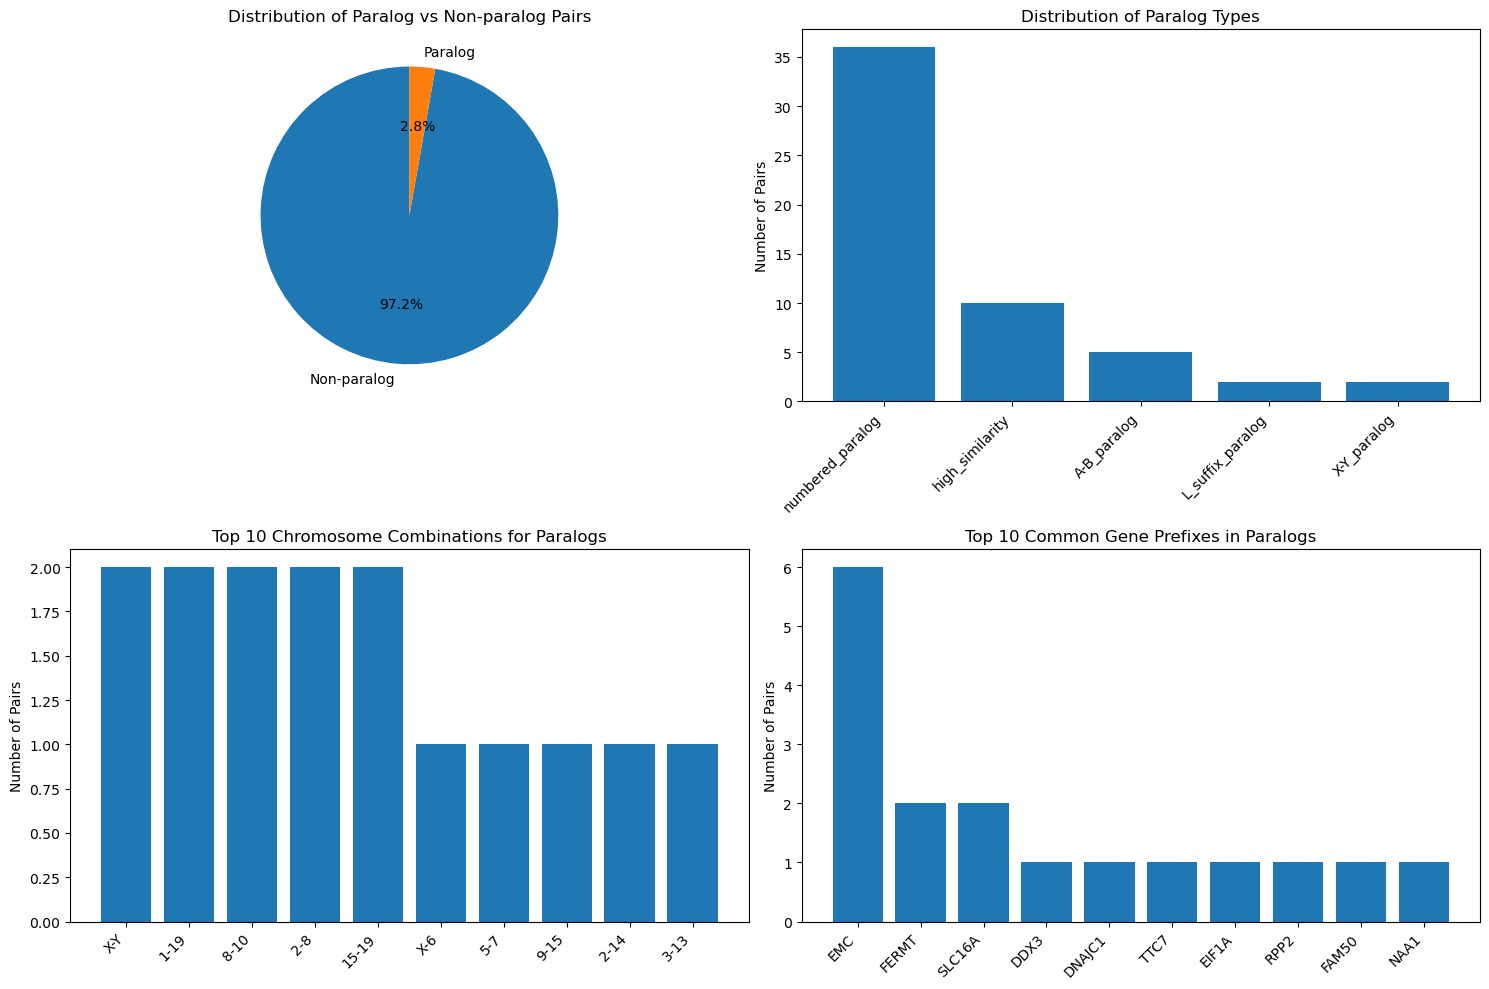


Results saved to: /home/scai/PhenPred/notebooks/validation_growth_tissue/paralog_analysis_results.csv

=== DETAILED STATISTICS ===
Total pairs analyzed: 1975
Paralog pairs found: 55
Non-paralog pairs: 1920
Percentage paralogs: 2.78%


In [125]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Paralog vs non-paralog distribution
paralog_counts = results_df['is_paralog'].value_counts()
axes[0, 0].pie(paralog_counts.values, labels=['Non-paralog', 'Paralog'], 
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribution of Paralog vs Non-paralog Pairs')

# Plot 2: Paralog types distribution
if len(all_paralogs) > 0:
    type_counts = all_paralogs_df['type'].value_counts()
    axes[0, 1].bar(range(len(type_counts)), type_counts.values)
    axes[0, 1].set_xticks(range(len(type_counts)))
    axes[0, 1].set_xticklabels(type_counts.index, rotation=45, ha='right')
    axes[0, 1].set_title('Distribution of Paralog Types')
    axes[0, 1].set_ylabel('Number of Pairs')

# Plot 3: Chromosomal distribution of paralogs
paralog_data = results_df[results_df['is_paralog'] == True]
if len(paralog_data) > 0:
    chr_combinations = paralog_data.apply(lambda x: f"{x['target_chr']}-{x['biomarker_chr']}", axis=1)
    chr_counts = chr_combinations.value_counts().head(10)
    axes[1, 0].bar(range(len(chr_counts)), chr_counts.values)
    axes[1, 0].set_xticks(range(len(chr_counts)))
    axes[1, 0].set_xticklabels(chr_counts.index, rotation=45, ha='right')
    axes[1, 0].set_title('Top 10 Chromosome Combinations for Paralogs')
    axes[1, 0].set_ylabel('Number of Pairs')

# Plot 4: Gene family prefix analysis
if len(all_paralogs) > 0:
    # Extract gene prefixes for paralog pairs
    prefixes = []
    for _, row in all_paralogs_df.iterrows():
        gene1, gene2 = row['gene1'], row['gene2']
        # Find common prefixes
        for i in range(min(len(gene1), len(gene2))):
            if gene1[i] != gene2[i]:
                break
        if i > 2:  # At least 3 character common prefix
            prefixes.append(gene1[:i])
    
    if prefixes:
        prefix_counts = pd.Series(prefixes).value_counts().head(10)
        axes[1, 1].bar(range(len(prefix_counts)), prefix_counts.values)
        axes[1, 1].set_xticks(range(len(prefix_counts)))
        axes[1, 1].set_xticklabels(prefix_counts.index, rotation=45, ha='right')
        axes[1, 1].set_title('Top 10 Common Gene Prefixes in Paralogs')
        axes[1, 1].set_ylabel('Number of Pairs')

plt.tight_layout()
plt.show()

# Save results
output_path = "/home/scai/PhenPred/notebooks/validation_growth_tissue/paralog_analysis_results.csv"
results_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Summary statistics
print(f"\n=== DETAILED STATISTICS ===")
print(f"Total pairs analyzed: {len(results_df)}")
print(f"Paralog pairs found: {len(results_df[results_df['is_paralog']])}")
print(f"Non-paralog pairs: {len(results_df[~results_df['is_paralog']])}")
print(f"Percentage paralogs: {len(results_df[results_df['is_paralog']])/len(results_df)*100:.2f}%")


In [126]:
# Validation and quality check
print("=== VALIDATION AND NEXT STEPS ===")

# Known paralog examples for validation
known_paralogs = [
    ('DDX3X', 'DDX3Y'),  # Well-known X-Y paralogs
    ('EIF1AX', 'EIF1AY'), # Translation initiation factors
    ('RPS4X', 'RPS4Y1'),  # Ribosomal proteins
    ('FAM50A', 'FAM50B'), # Gene family members
    ('LDHA', 'LDHB'),     # Lactate dehydrogenases
]

print("Checking known paralog examples in our results:")
for gene1, gene2 in known_paralogs:
    found = False
    for paralog in all_paralogs:
        if (paralog['gene1'] == gene1 and paralog['gene2'] == gene2) or \
           (paralog['gene1'] == gene2 and paralog['gene2'] == gene1):
            print(f"✓ {gene1} ↔ {gene2}: Found as {paralog['type']} ({paralog['pattern']})")
            found = True
            break
    if not found:
        # Check if the pair exists in the coverage matrix
        pair_exists = ((coverage_matrix['target_gene'] == gene1) & 
                      (coverage_matrix['biomarker_gene'] == gene2)).any() or \
                     ((coverage_matrix['target_gene'] == gene2) & 
                      (coverage_matrix['biomarker_gene'] == gene1)).any()
        if pair_exists:
            print(f"⚠ {gene1} ↔ {gene2}: Present in matrix but not detected as paralog")
        else:
            print(f"- {gene1} ↔ {gene2}: Not present in coverage matrix")

print(f"\n=== RECOMMENDATIONS FOR FURTHER VALIDATION ===")
print("1. Cross-reference with Ensembl Compara database for ortholog/paralog relationships")
print("2. Use HGNC gene families to validate gene family classifications")
print("3. Check sequence similarity using BLAST or similar tools")
print("4. Validate using HomoloGene database from NCBI")
print("5. Consider protein domain analysis for functional similarity")

print(f"\n=== WEB RESOURCES FOR VALIDATION ===")
print("- Ensembl Compara: https://www.ensembl.org/info/genome/compara/")
print("- HGNC Gene Families: https://www.genenames.org/")
print("- NCBI HomoloGene: https://www.ncbi.nlm.nih.gov/homologene")
print("- Pfam protein families: https://pfam.xfam.org/")

# Export paralog pairs for external validation
paralog_pairs_for_validation = pd.DataFrame([
    {'gene1': p['gene1'], 'gene2': p['gene2'], 'type': p['type'], 'pattern': p['pattern']} 
    for p in all_paralogs
])

validation_path = "/home/scai/PhenPred/notebooks/validation_growth_tissue/paralog_pairs_for_validation.csv"
paralog_pairs_for_validation.to_csv(validation_path, index=False)
print(f"\nParalog pairs exported for validation: {validation_path}")

# Final summary
print(f"\n=== FINAL SUMMARY ===")
print(f"• Found {len(all_paralogs)} potential paralog pairs out of {len(coverage_matrix)} total pairs")
print(f"• This represents {len(all_paralogs)/len(coverage_matrix)*100:.1f}% of all gene pairs")
print(f"• Main types: X-Y paralogs, A-B paralogs, numbered paralogs, and gene families")
print(f"• Results saved with paralog annotations for further analysis")
print(f"• Validation recommended using external databases")


=== VALIDATION AND NEXT STEPS ===
Checking known paralog examples in our results:
✓ DDX3X ↔ DDX3Y: Found as X-Y_paralog (DDX3X/Y)
✓ EIF1AX ↔ EIF1AY: Found as X-Y_paralog (EIF1AX/Y)
- RPS4X ↔ RPS4Y1: Not present in coverage matrix
✓ FAM50A ↔ FAM50B: Found as A-B_paralog (FAM50A/B)
- LDHA ↔ LDHB: Not present in coverage matrix

=== RECOMMENDATIONS FOR FURTHER VALIDATION ===
1. Cross-reference with Ensembl Compara database for ortholog/paralog relationships
2. Use HGNC gene families to validate gene family classifications
3. Check sequence similarity using BLAST or similar tools
4. Validate using HomoloGene database from NCBI
5. Consider protein domain analysis for functional similarity

=== WEB RESOURCES FOR VALIDATION ===
- Ensembl Compara: https://www.ensembl.org/info/genome/compara/
- HGNC Gene Families: https://www.genenames.org/
- NCBI HomoloGene: https://www.ncbi.nlm.nih.gov/homologene
- Pfam protein families: https://pfam.xfam.org/

Paralog pairs exported for validation: /home/sca